# Define the Problem Statement

**The Evolution of Women's Health Coverage in The New York Times**
<br> <br>
**Research Question:** To what extent has the volume, thematic focus, and sentiment of women's health coverage in The New York Times evolved over the past two decades?
<br> <br>
**Data Source:** New York Times articles sourced from NYT API. Data set contains date, abstract, lead paragraph, print section, keywords etc.
<br> <br>
**Expected Results:** I expect to find an increase in overall volume of articles covering women's health and a shift in themes from more reproductive focused to more over encompassing discussion of topics like healthcare equity.
<br> <br>
**Why This Question Is Important:** The question is important because women’s health is an often underrepresented topic in media coverage and scientific studies so hopefully the project will provide data-driven analysis to offer actionable intelligence to media organizations, health advocates, and companies, creating a roadmap to correct blind spots and better prioritize women's health issues.


# Data Acquisition

## Getting Articles from NYT API

In [ ]:


import asyncio
import os
import sys
import aiohttp
import pandas as pd
from typing import List, Dict, Any

API_KEY = os.getenv("NYT_API_KEY", "PQepQBSs9AQPcHmyAPEGZ70JsZZyyi1W")

YEARS = [
    2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
    2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
]


async def fetch_month_data(
    session: aiohttp.ClientSession, year: int, month: int, max_retries: int = 3
) -> List[Dict[str, Any]]:
    """
    Asynchronously fetches and processes article data for a single month,
    with a retry mechanism for rate limiting.
    """
    url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={API_KEY}"

    for attempt in range(max_retries):
        print(f"Fetching data for {year}-{month:02d} (Attempt {attempt + 1})...")
        try:
            async with session.get(url) as response:
                response.raise_for_status()

                if "application/json" not in response.headers.get("Content-Type", ""):
                    print(f"  > Warning: Non-JSON response for {year}-{month:02d}. Skipping.")
                    return []

                data = await response.json()
                docs = data.get("response", {}).get("docs", [])

                print(f"  > Found {len(docs)} documents for {year}-{month:02d}.")

                monthly_articles = []
                for article in docs:
                    if article.get("document_type") == "article" and article.get("headline", {}).get("main"):
                        keywords = [kw.get("value") for kw in article.get("keywords", []) if "value" in kw]
                        monthly_articles.append({
                            "year": year,
                            "month": month,
                            "headline": article["headline"]["main"],
                            "lead_paragraph": article.get("lead_paragraph", "N/A"),
                            "news_desk": article.get("news_desk", "N/A"),
                            "keywords": ", ".join(keywords),
                        })

                print(f"  > Processed and added {len(monthly_articles)} articles.")
                return monthly_articles # Success!

        except aiohttp.ClientError as e:
            if e.status == 429:
                if attempt < max_retries - 1:
                    wait_time = (2 ** attempt) * 6
                    print(f"  > Rate limit hit for {year}-{month:02d}. Retrying in {wait_time} seconds...")
                    await asyncio.sleep(wait_time)
                    continue
                else:
                    print(f"  >>> Please verify your key at the NYT Developer Portal.\n")
                    return []
            else:
                print(f"  >>> HTTP error for {year}-{month:02d}: {e}")
                return []
        except asyncio.TimeoutError:
            print(f"  >>> Request timed out for {year}-{month:02d}.")
            return []
        except Exception as e:
            print(f"  >>> An unexpected error occurred for {year}-{month:02d}: {e}")
            return []

    print(f"  >>> Failed to fetch data for {year}-{month:02d} after {max_retries} attempts.")
    return []

# --- Main Orchestration Function ---

async def main() -> pd.DataFrame:
    """
    Main function to orchestrate the fetching of all data and return a DataFrame.
    """
    # --- CRITICAL API KEY CHECK ---
    if not API_KEY or API_KEY == "YOUR_API_KEY_HERE":
        print("!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
        print("!!! ERROR: NYT_API_KEY is not set.")
        return pd.DataFrame()

    print(f"--- Using API Key ending in: '...{API_KEY[-4:]}' ---")

    all_articles = []

    timeout = aiohttp.ClientTimeout(total=60)
    async with aiohttp.ClientSession(timeout=timeout) as session:
        tasks = [
            fetch_month_data(session, year, month)
            for year in YEARS
            for month in range(1, 13)
        ]

        # Process tasks one by one to avoid sending a burst of requests.
        for i, task in enumerate(tasks):
            month_result = await task
            if month_result:
                all_articles.extend(month_result)

            if i < len(tasks) - 1:
                print("--- Waiting 13 seconds before next request ---")
                await asyncio.sleep(12)

    print(f"\nFinished fetching data! Found a total of {len(all_articles)} articles.")

    if not all_articles:
        return pd.DataFrame()

    return pd.DataFrame(all_articles)

# --- Execution Block ---

print("Starting article fetching process...")
my_dataframe = await main()

print("\n--- Final DataFrame Info ---")
if not my_dataframe.empty:
    print(my_dataframe.head())
    print("\nDataFrame Info:")
    my_dataframe.info()
else:
    print("The final DataFrame is empty.")



Starting article fetching process...
--- Using API Key ending in: '...yi1W' ---
Fetching data for 2004-01 (Attempt 1)...
  > Found 8810 documents for 2004-01.
  > Processed and added 8728 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-02 (Attempt 1)...
  > Found 8750 documents for 2004-02.
  > Processed and added 8657 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-03 (Attempt 1)...
  > Found 8986 documents for 2004-03.
  > Processed and added 8892 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-04 (Attempt 1)...
  > Found 8519 documents for 2004-04.
  > Processed and added 8428 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-05 (Attempt 1)...
  > Found 8899 documents for 2004-05.
  > Processed and added 8812 articles.
--- Waiting 13 seconds before next request ---
Fetching data for 2004-06 (Attempt 1)...
  > Found 8436 documents for 2004-06.
  > Processed an

In [ ]:
# Saving data
output_filename = "nyt_articles_04-24_new.csv"
my_dataframe.to_csv(output_filename, index=False)


## Data Preprocessing / Preparation

In [ ]:
my_dataframe.head()

,year,month,headline,lead_paragraph,news_desk,keywords
0,2004,1,FreeMarkets Agrees to Buy Auction Unit of Covi...,"FreeMarkets, which makes Internet-auction soft...",Business/Financial Desk,"General Motors Corp, Ford Motor Co, DaimlerChr..."
1,2004,1,National Briefing | South: Arkansas: Assembly ...,Both houses of the General Assembly recessed u...,National Desk,
2,2004,1,Clark Courts Veterans in Swing Through South,Winding up several days of campaigning in the ...,National Desk,"Southern States (US), Health Insurance and Man..."
3,2004,1,"Paid Notice: Deaths PAONE, NICOLA","PAONE--Nicola. On December 25, 2003 at age 88....",Classified,"PAONE, NICOLA"
4,2004,1,The Time We Thought We Knew,"It was an unlikely place to be at 4:30 a.m., s...",Editorial Desk,"Newton, Isaac, Einstein, Albert, Time, RELATIV..."


In [ ]:
# Check News Desk Types

news_desk_counts = my_dataframe['news_desk'].value_counts()
news_desk_counts.head()

,count
news_desk,
,196434
Business,166120
Foreign,112071
Culture,98841
National,91503


In [ ]:
# What kind of article doesn't have news_desk?

empty_news_desk_df = my_dataframe[my_dataframe['news_desk'] == ""]
display(empty_news_desk_df.head(2))

,year,month,headline,lead_paragraph,news_desk,keywords
1141,2004,1,"Ooh, You’re In Trouble!",Note: This lesson was originally published on ...,,
1436,2004,1,Destination Red Planet,Note: This lesson was originally published on ...,,


In [ ]:
# List of news desks to remove
desks_to_remove = ['Classified', 'Paid Notice']
cleaned_df = my_dataframe[~my_dataframe['news_desk'].isin(desks_to_remove)]

# Verify the changes
print(f"Original dataframe shape: {my_dataframe.shape}")
print(f"Cleaned dataframe shape: {cleaned_df.shape}")

Original dataframe shape: (1707542, 6)
Cleaned dataframe shape: (1675323, 6)

News desk counts after cleaning:
news_desk
                       196434
Business               166120
Foreign                112071
Culture                 98841
National                91503
                        ...  
Arts / Arts Special         1
OurTimes                    1
IHT Finance                 1
Chinese                     1
InteractiveNews             1
Name: count, Length: 332, dtype: int64


In [ ]:
# Additionally remove obituary and film reviews just in case

df = cleaned_df[~cleaned_df['headline'].str.contains('Obituary|Paid Notice: Deaths|Correction|Film|Note: ', case=False, na=False)].copy()
df_clean = df[~df['lead_paragraph'].str.contains('Obituary|Paid Notice: Deaths|Correction|Film|Note: ', case=False, na=False)].copy()


In [ ]:
df_clean.head(10)

,year,month,headline,lead_paragraph,news_desk,keywords
0,2004,1,FreeMarkets Agrees to Buy Auction Unit of Covi...,"FreeMarkets, which makes Internet-auction soft...",Business/Financial Desk,"General Motors Corp, Ford Motor Co, DaimlerChr..."
1,2004,1,National Briefing | South: Arkansas: Assembly ...,Both houses of the General Assembly recessed u...,National Desk,
2,2004,1,Clark Courts Veterans in Swing Through South,Winding up several days of campaigning in the ...,National Desk,"Southern States (US), Health Insurance and Man..."
4,2004,1,The Time We Thought We Knew,"It was an unlikely place to be at 4:30 a.m., s...",Editorial Desk,"Newton, Isaac, Einstein, Albert, Time, RELATIV..."
5,2004,1,Mad Cow Disease: Lessons Unlearned (4 Letters),To the Editor:,Opinion,"Blair, David W, Food Contamination and Poisoni..."
6,2004,1,Giants Want a Teacher Who Is Adept at Winning,As the Giants interview prospective head coach...,Sports Desk,"New England Patriots, New York Giants, Crennel..."
7,2004,1,An Odd Sight in Iran as Aid Team Tents Go Up: ...,"For the past 24 years, the Stars and Stripes w...",Foreign Desk,"Iran, Bam (Iran), RED CRESCENT, Earthquakes, F..."
8,2004,1,Mad Cow Disease: Lessons Unlearned,To the Editor:,Editorial Desk,"DALLARI, STELA MARIS, Livestock, Meat, Mad Cow..."
9,2004,1,Art Meets Artichoke,"JEAN-CLAUDE NEDELEC, an owner of Glorious Food...",House & Home/Style Desk,"Gund, Agnes, Shapiro, Daniel, Dochantschi, Mar..."
12,2004,1,"A Place to Store Your Pictures, and to Show Th...","Small, portable hard drives have offered the t...",Circuits,"Epson Co, Prices (Fares, Fees and Rates), Phot..."


In [ ]:
# Save cleaned dataframe
df_clean.to_csv('/content/drive/My Drive/capstone_nyt_articles.csv', index=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Classification and Manual Review

In [ ]:
# Creating Column to Combine all Inputs

df = df_clean.copy()
df['new'] = df['headline'].fillna('') + ' ' + df['lead_paragraph'].fillna('') + ' ' + df['keywords'].fillna('')
df.head(4)

,year,month,headline,lead_paragraph,news_desk,keywords,new
0,2004,1,FreeMarkets Agrees to Buy Auction Unit of Covi...,"FreeMarkets, which makes Internet-auction soft...",Business/Financial Desk,"General Motors Corp, Ford Motor Co, DaimlerChr...",FreeMarkets Agrees to Buy Auction Unit of Covi...
1,2004,1,National Briefing | South: Arkansas: Assembly ...,Both houses of the General Assembly recessed u...,National Desk,,National Briefing | South: Arkansas: Assembly ...
2,2004,1,Clark Courts Veterans in Swing Through South,Winding up several days of campaigning in the ...,National Desk,"Southern States (US), Health Insurance and Man...",Clark Courts Veterans in Swing Through South W...
4,2004,1,The Time We Thought We Knew,"It was an unlikely place to be at 4:30 a.m., s...",Editorial Desk,"Newton, Isaac, Einstein, Albert, Time, RELATIV...",The Time We Thought We Knew It was an unlikely...


In [ ]:
# Code below does a first pass in classifying articles in women's health related or not

import os
import re

TEXT_COLUMN = 'new'
KEYWORD_THRESHOLD = 1

WOMENS_HEALTH_KEYWORDS = set([
    # Pregnancy & Reproduction
    'pregnancy', 'pregnant', 'prenatal', 'postpartum', 'postnatal', 'obstetrics', 'obstetric',
    'gynecology', 'gynecologist', 'fertility', 'infertility', 'ivf', 'iui', 'contraception',
    'birth control', 'iud', 'fetus', 'fetal', 'embryo', 'miscarriage', 'stillbirth', 'childbirth',
    'breastfeeding', 'lactation', 'maternity', 'c-section', 'cesarean', 'amniotic', 'placenta',
    'midwifery', 'doula', 'ob-gyn', 'egg freezing', 'oocyte',

    # Cancers & Screenings
    'breast cancer', 'ovarian cancer', 'cervical cancer', 'uterine cancer', 'vaginal cancer', 'vulvar cancer',
    'mammogram', 'pap smear', 'pap test', 'hpv', 'human papillomavirus', 'lumpectomy', 'mastectomy',
    'colposcopy', 'brca',

    # Conditions & Syndromes
    'endometriosis', 'pcos', 'polycystic ovary syndrome', 'menopause', 'perimenopause',
    'uterine fibroids', 'pelvic inflammatory disease', 'pid', 'osteoporosis',
    'menstrual', 'menstruation', 'period', 'premenstrual syndrome', 'pms', 'pmdd',
    'yeast infection', 'bacterial vaginosis', 'vulvodynia', 'adenomyosis', 'toxic shock syndrome',
    'pelvic organ prolapse', 'cystitis',

    # Procedures & Anatomy
    'uterus', 'uterine', 'ovary', 'ovarian', 'cervix', 'vagina', 'vaginal', 'vulva',
    'pelvic floor', 'fallopian', 'hysterectomy', 'oophorectomy', 'hormone replacement therapy', 'hrt',

    # Others / Catch-all

    "abortion", "amniocentesis", "birth control", "breast cancer", "c-section",
    "cervical cancer", "cesarean section", "childbirth", "contraception",
    "dysmenorrhea", "ectopic pregnancy", "egg freezing", "endometriosis",
    "family planning", "female infertility", "fertility", "gestational diabetes",
    "gynecology", "hormone replacement therapy", "hot flashes", "hpv",
    "human papillomavirus", "hysterectomy", "in vitro fertilization", "iud", "ivf",
    "mammogram", "maternal health", "menarche", "menopause", "menstrual cycle",
    "miscarriage", "ob-gyn", "obstetrics", "oophorectomy", "osteoporosis",
    "ovarian cancer", "ovulation", "pap smear", "pelvic inflammatory disease",
    "perimenopause", "pcos", "pms", "polycystic ovary syndrome",
    "postpartum depression", "preeclampsia", "pregnancy", "prenatal",
    "premenstrual syndrome", "reproductive health", "stillbirth",
    "toxic shock syndrome", "urinary tract infection", "uterine cancer",
    "uterine fibroids", "uterus", "uti", "vagina", "vaginitis", "vulvodynia",
    "women's health", "yeast infection"

])

# STEP 1
def count_keywords_in_text(text, keywords):
    """
    Counts the number of unique keywords from a given set found in a text string.
    """
    text_lower = str(text).lower()
    # The \b ensures we match whole words only (e.g., 'pms' not 'symptoms')
    found_keywords = {
        keyword for keyword in keywords
        if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower)
    }
    return len(found_keywords)

# STEP 2
def classify_dataframe(df, keywords, text_column, threshold):
    """
    Processes a DataFrame to count keywords and assign a classification label.
    """
    df_copy = df.copy()
    df_copy.dropna(subset=[text_column], inplace=True)

    df_copy['keyword_match_count'] = df_copy[text_column].apply(
        lambda txt: count_keywords_in_text(txt, keywords)
    )
    df_copy['is_womens_health'] = df_copy['keyword_match_count'].apply(
        lambda count: True if count >= threshold else False
    )

    classified_count = df_copy['is_womens_health'].sum()
    print(f"Found {classified_count} matching articles in the DataFrame.")

    return df_copy

processed_df = classify_dataframe(df, WOMENS_HEALTH_KEYWORDS, TEXT_COLUMN, KEYWORD_THRESHOLD)


Found 22066 matching articles in the DataFrame.


In [ ]:
processed_df.head()

,year,month,headline,lead_paragraph,news_desk,keywords,new,keyword_match_count,is_womens_health
0,2004,1,FreeMarkets Agrees to Buy Auction Unit of Covi...,"FreeMarkets, which makes Internet-auction soft...",Business/Financial Desk,"General Motors Corp, Ford Motor Co, DaimlerChr...",FreeMarkets Agrees to Buy Auction Unit of Covi...,0,False
1,2004,1,National Briefing | South: Arkansas: Assembly ...,Both houses of the General Assembly recessed u...,National Desk,,National Briefing | South: Arkansas: Assembly ...,0,False
2,2004,1,Clark Courts Veterans in Swing Through South,Winding up several days of campaigning in the ...,National Desk,"Southern States (US), Health Insurance and Man...",Clark Courts Veterans in Swing Through South W...,0,False
4,2004,1,The Time We Thought We Knew,"It was an unlikely place to be at 4:30 a.m., s...",Editorial Desk,"Newton, Isaac, Einstein, Albert, Time, RELATIV...",The Time We Thought We Knew It was an unlikely...,0,False
5,2004,1,Mad Cow Disease: Lessons Unlearned (4 Letters),To the Editor:,Opinion,"Blair, David W, Food Contamination and Poisoni...",Mad Cow Disease: Lessons Unlearned (4 Letters)...,0,False


In [ ]:
# Doing the same but for men's health for comparison later on

TEXT_COLUMN = 'new'
KEYWORD_THRESHOLD = 1

MENS_HEALTH_KEYWORDS = set([
    "androgen", "andropause", "balanitis", "benign prostatic hyperplasia",
    "bph", "delayed ejaculation", "epididymitis", "erectile dysfunction",
    "gynecomastia", "hydrocele", "hypogonadism", "inguinal hernia", "jock itch",
    "low-t", "male infertility", "male pattern baldness", "men's health",
    "orchitis", "penis", "peyronie's disease", "premature ejaculation",
    "prostate", "prostate cancer", "prostate-specific antigen", "prostatectomy",
    "prostatitis", "psa test", "scrotum", "semen analysis", "sperm count",
    "testicles", "testicular cancer", "testicular torsion", "testosterone",
    "urologist", "urology", "varicocele", "vasectomy"

])

# STEP 1
def count_keywords_in_text(text, keywords):
    """
    Counts the number of unique keywords from a given set found in a text string.
    """
    text_lower = str(text).lower()
    # The \b ensures we match whole words only (e.g., 'pms' not 'symptoms')
    found_keywords = {
        keyword for keyword in keywords
        if re.search(r'\b' + re.escape(keyword) + r'\b', text_lower)
    }
    return len(found_keywords)

# STEP 2
def classify_dataframe(df, keywords, text_column, threshold):
    """
    Processes a DataFrame to count keywords and assign a classification label.
    """
    if text_column not in df.columns:
        print(f"Error: Text column '{text_column}' not found in the DataFrame. Aborting.")
        return df

    df_copy = processed_df.copy()
    df_copy.dropna(subset=[text_column], inplace=True)

    df_copy['keyword_match_count_men'] = df_copy[text_column].apply(
        lambda txt: count_keywords_in_text(txt, keywords)
    )
    df_copy['is_men_health'] = df_copy['keyword_match_count_men'].apply(
        lambda count: True if count >= threshold else False
    )

    classified_count = df_copy['is_men_health'].sum()
    print(f"Found {classified_count} matching articles in the DataFrame.")

    return df_copy

processed_df_final = classify_dataframe(processed_df, MENS_HEALTH_KEYWORDS, TEXT_COLUMN, KEYWORD_THRESHOLD)


Found 1487 matching articles in the DataFrame.


In [ ]:
processed_df_final.head()

,year,month,headline,lead_paragraph,news_desk,keywords,new,keyword_match_count,is_womens_health,keyword_match_count_men,is_men_health
0,2004,1,FreeMarkets Agrees to Buy Auction Unit of Covi...,"FreeMarkets, which makes Internet-auction soft...",Business/Financial Desk,"General Motors Corp, Ford Motor Co, DaimlerChr...",FreeMarkets Agrees to Buy Auction Unit of Covi...,0,False,0,False
1,2004,1,National Briefing | South: Arkansas: Assembly ...,Both houses of the General Assembly recessed u...,National Desk,,National Briefing | South: Arkansas: Assembly ...,0,False,0,False
2,2004,1,Clark Courts Veterans in Swing Through South,Winding up several days of campaigning in the ...,National Desk,"Southern States (US), Health Insurance and Man...",Clark Courts Veterans in Swing Through South W...,0,False,0,False
4,2004,1,The Time We Thought We Knew,"It was an unlikely place to be at 4:30 a.m., s...",Editorial Desk,"Newton, Isaac, Einstein, Albert, Time, RELATIV...",The Time We Thought We Knew It was an unlikely...,0,False,0,False
5,2004,1,Mad Cow Disease: Lessons Unlearned (4 Letters),To the Editor:,Opinion,"Blair, David W, Food Contamination and Poisoni...",Mad Cow Disease: Lessons Unlearned (4 Letters)...,0,False,0,False


In [ ]:
# Saving data frame

processed_df_final.to_csv('/content/drive/My Drive/capstone_classification.csv', index=False)

In [ ]:
# Download for Manual Check - Women's Health

In [ ]:
random_sample_df = processed_df_final.groupby('is_womens_health').sample(n=1000, random_state=42)
output_filename = '2k_sample_manual.csv'
random_sample_df.to_csv(output_filename, index=False)

In [1]:
# Manual Review in Spreadsheet https://docs.google.com/spreadsheets/d/1G1RXctfiVXHJzYvMW_BswFLyqA40dxjrYsOyHqJfoNU/edit?gid=382174875#gid=382174875
# Adding back to the colab

from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
manual_review = pd.read_csv('/content/drive/MyDrive/manual_review_capstone.csv')


Mounted at /content/drive


In [6]:
# Download for Manual Check - Mens's Health

random_sample_men_df = new_df.groupby('is_men_health').sample(n=1000, random_state=42)
output_filename = '2k_sample_manual_mens.csv'
random_sample_men_df.to_csv(output_filename, index=False)

# Manual Review in Spreadsheet
# Adding back to the colab

manual_review = pd.read_csv('/content/drive/MyDrive/2k_sample_manual_mens.csv')


In [ ]:
manual_review.head()

,year,month,headline,lead_paragraph,news_desk,keywords,new,keyword_match_count,is_womens_health,keyword_match_count_men,is_men_health
0,2013,10,Scientists Go Back to Work and a Skull Changes...,“I brought some muffins!” proclaimed Vice Pres...,Science,"Prostate Gland, Quenqua, Douglas, Science and ...",Scientists Go Back to Work and a Skull Changes...,0,False,2,True
1,2016,2,"Testosterone Gel Has Modest Benefits for Men, ...",More than a million men have smeared testoster...,National,"Kolata, Gina, Testosterone, Drugs (Pharmaceuti...","Testosterone Gel Has Modest Benefits for Men, ...",0,False,1,True
2,2021,5,"Ro, a health care start-up, will acquire Moder...","Ro, the parent company of Roman, the brand tha...",Business,"Women and Girls, Medicine and Health, Venture ...","Ro, a health care start-up, will acquire Moder...",1,True,1,True
3,2018,12,Do Cruciferous Vegetables Really Fight Cancer?,Q. Are cruciferous vegetables really helpful f...,Well,"Vegetables, Head and Neck Cancer, Colon and Co...",Do Cruciferous Vegetables Really Fight Cancer?...,1,True,1,True
4,2019,1,Review: A Netflix Legal Thriller Weighs Genoci...,"In “Black Earth Rising,” new Friday on Netflix...",Weekend,"Television, Netflix Inc, Black Earth Rising (T...",Review: A Netflix Legal Thriller Weighs Genoci...,1,True,2,True


# Building the Model

I built an XGBoost model using TF-IDF vectorization. I chose XGBoost because it's one of the best-performing algorithms for text classification. The model captures both single words and two-word phrases through bigrams, focusing on the 5k most important features. Since the dataset had class imbalance, I weighted the minority class higher during training. I tuned hyperparameters through randomized search with 5-fold cross-validation, optimizing for F1 score rather than accuracy.

In [15]:
# Import Manual Classification

from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
manual_df = pd.read_csv('/content/drive/MyDrive/manual_review_capstone.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
manual_df.head(2)

,year,month,headline,lead_paragraph,news_desk,keywords,new,keyword_match_count,is_womens_health,keyword_match_count_men,is_men_health
0,2013,10,Scientists Go Back to Work and a Skull Changes...,“I brought some muffins!” proclaimed Vice Pres...,Science,"Prostate Gland, Quenqua, Douglas, Science and ...",Scientists Go Back to Work and a Skull Changes...,0,False,2,True
1,2016,2,"Testosterone Gel Has Modest Benefits for Men, ...",More than a million men have smeared testoster...,National,"Kolata, Gina, Testosterone, Drugs (Pharmaceuti...","Testosterone Gel Has Modest Benefits for Men, ...",0,False,1,True


In [17]:
# Building the Model for Women's Health  #

import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report


X_text = manual_df['new']
y = manual_df['is_womens_health']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.3, random_state=42, stratify=y
)

#Vectorize w/ TFIDF
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 2)
)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_text)
X_test_tfidf = tfidf_vectorizer.transform(X_test_text)


#Hyperparameter

scale_pos_weight = y_train.value_counts()[False] / y_train.value_counts()[True]

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

#XGBoost
xgb_model = xgb.XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

#Randomized Search with cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=25,
    scoring='f1',
    n_jobs=-1,
    cv=5,
    random_state=42
)

random_search.fit(X_train_tfidf, y_train)

print(f"\nBest parameters: {random_search.best_params_}")

best_classifier = random_search.best_estimator_
y_pred = best_classifier.predict(X_test_tfidf)
print(classification_report(y_test, y_pred))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [00:20:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Best parameters: {'subsample': 0.9, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
              precision    recall  f1-score   support

       False       0.94      0.99      0.96       300
        True       0.99      0.94      0.96       300

    accuracy                           0.96       600
   macro avg       0.96      0.96      0.96       600
weighted avg       0.96      0.96      0.96       600



In [ ]:
# Saving The Model

import joblib

joblib.dump(best_classifier, 'womens_health_classifier.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
# Importing Back Full Data Set

full_df = pd.read_csv('/content/drive/MyDrive/capstone_nyt_articles.csv')


## Model Evaluation

I've focused on F1 result for the model because it ensures women's health articles are correctly categorized balacing two important factors: how accurate our positive predictions are (precision) and how many actual positives we catch (recall). Since both false positives and false negatives matter for classifying women's health articles, we need a metric that penalizes both equally.

Model's F1 = 96%

## Applying Model to Full Dataset

In [ ]:
#Applying for Women's Health

final_df_model = full_df.copy()
final_df_model['concatenate'] = full_df['headline'].fillna('') + ' ' + full_df['lead_paragraph'].fillna('') + ' ' + full_df['keywords'].fillna('')

#womens
loaded_classifier = joblib.load('womens_health_classifier.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')

#womens
X_full_dataset_tfidf = loaded_vectorizer.transform(final_df_model['concatenate'])
predictions = loaded_classifier.predict(X_full_dataset_tfidf)
probabilities = loaded_classifier.predict_proba(X_full_dataset_tfidf)
confidence_scores = probabilities[:, 1]

final_df_model['is_womens_health_pred'] = predictions
final_df_model['confidence_score'] = confidence_scores
final_df_model.head()


,year,month,headline,lead_paragraph,news_desk,keywords,concatenate,is_womens_health_pred,confidence_score
0,2004,1,FreeMarkets Agrees to Buy Auction Unit of Covi...,"FreeMarkets, which makes Internet-auction soft...",Business/Financial Desk,"General Motors Corp, Ford Motor Co, DaimlerChr...",FreeMarkets Agrees to Buy Auction Unit of Covi...,0,0.043987
1,2004,1,National Briefing | South: Arkansas: Assembly ...,Both houses of the General Assembly recessed u...,National Desk,NaN,National Briefing | South: Arkansas: Assembly ...,0,0.072049
2,2004,1,Clark Courts Veterans in Swing Through South,Winding up several days of campaigning in the ...,National Desk,"Southern States (US), Health Insurance and Man...",Clark Courts Veterans in Swing Through South W...,0,0.324667
3,2004,1,The Time We Thought We Knew,"It was an unlikely place to be at 4:30 a.m., s...",Editorial Desk,"Newton, Isaac, Einstein, Albert, Time, RELATIV...",The Time We Thought We Knew It was an unlikely...,0,0.063922
4,2004,1,Mad Cow Disease: Lessons Unlearned (4 Letters),To the Editor:,Opinion,"Blair, David W, Food Contamination and Poisoni...",Mad Cow Disease: Lessons Unlearned (4 Letters)...,0,0.127122


In [ ]:
# And Save

final_df_model.to_csv('/content/drive/My Drive/capstone_classified_model.csv', index=False)


# Analysis Part I: what did we learn so far?

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import numpy as np


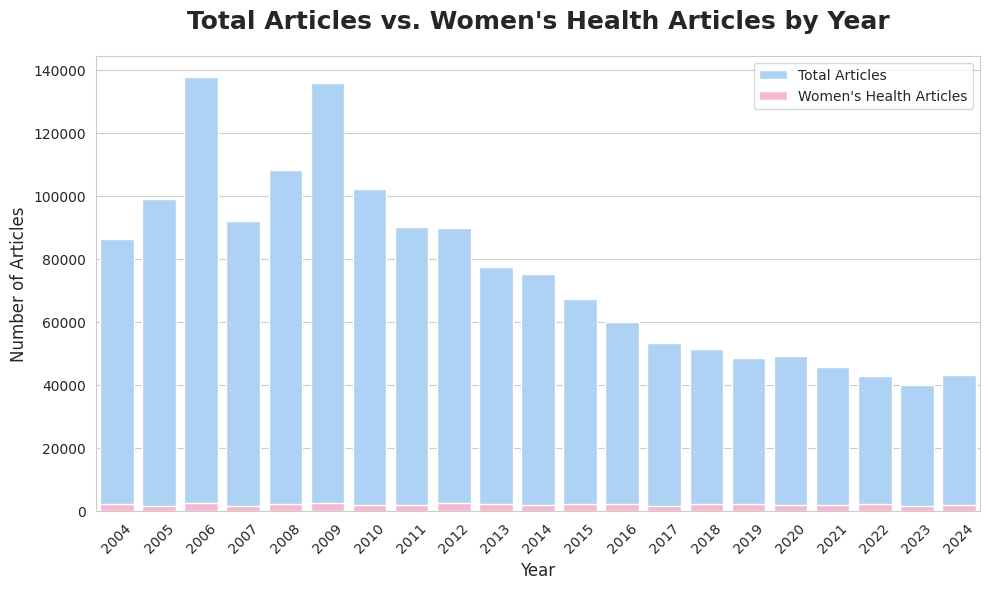

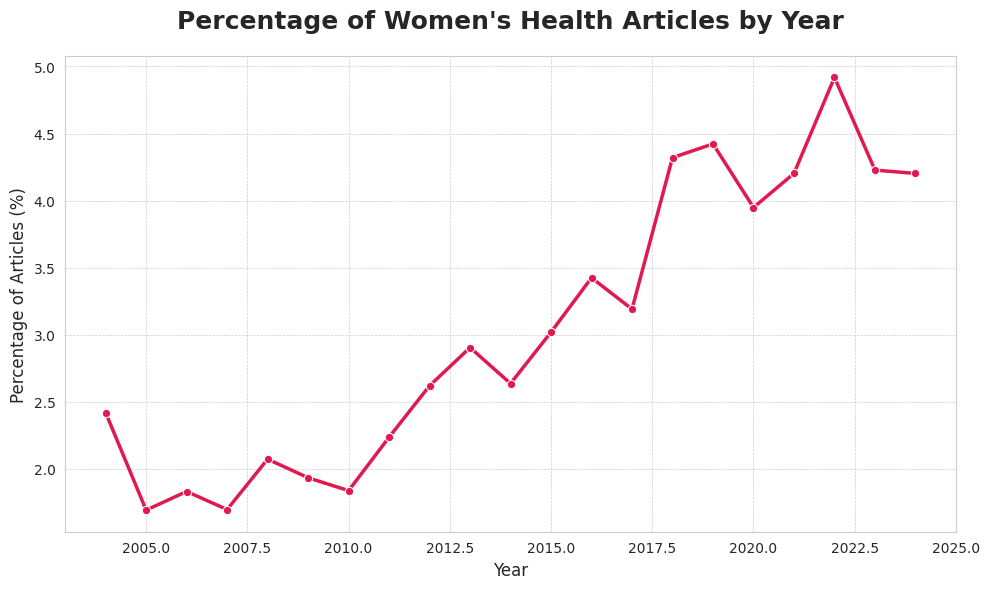

In [ ]:
#Total articles per year
total_articles_per_year = final_df_model['year'].value_counts().sort_index().reset_index()
total_articles_per_year.columns = ['year', 'total_articles']

#Women's health articles per year
womens_health_df = full_df[final_df_model['is_womens_health_pred'] == 1]
womens_health_articles_per_year = womens_health_df['year'].value_counts().sort_index().reset_index()
womens_health_articles_per_year.columns = ['year', 'womens_health_articles']

#Merge
yearly_summary = pd.merge(total_articles_per_year, womens_health_articles_per_year, on='year', how='left').fillna(0)
yearly_summary['womens_health_articles'] = yearly_summary['womens_health_articles'].astype(int)

#%
yearly_summary['percentage_womens_health'] = (yearly_summary['womens_health_articles'] / yearly_summary['total_articles']) * 100

#Plots
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

sns.barplot(x='year', y='total_articles', data=yearly_summary, color='#a2d2ff', label='Total Articles', ax=ax1)
sns.barplot(x='year', y='womens_health_articles', data=yearly_summary, color='#ffafcc', label="Women's Health Articles", ax=ax1)

ax1.set_title('Total Articles vs. Women\'s Health Articles by Year', fontsize=18, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Number of Articles', fontsize=12)
ax1.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='percentage_womens_health', data=yearly_summary, marker='o', color='#e01a4f', linewidth=2.5)
plt.title("Percentage of Women's Health Articles by Year", fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel("Percentage of Articles (%)", fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()



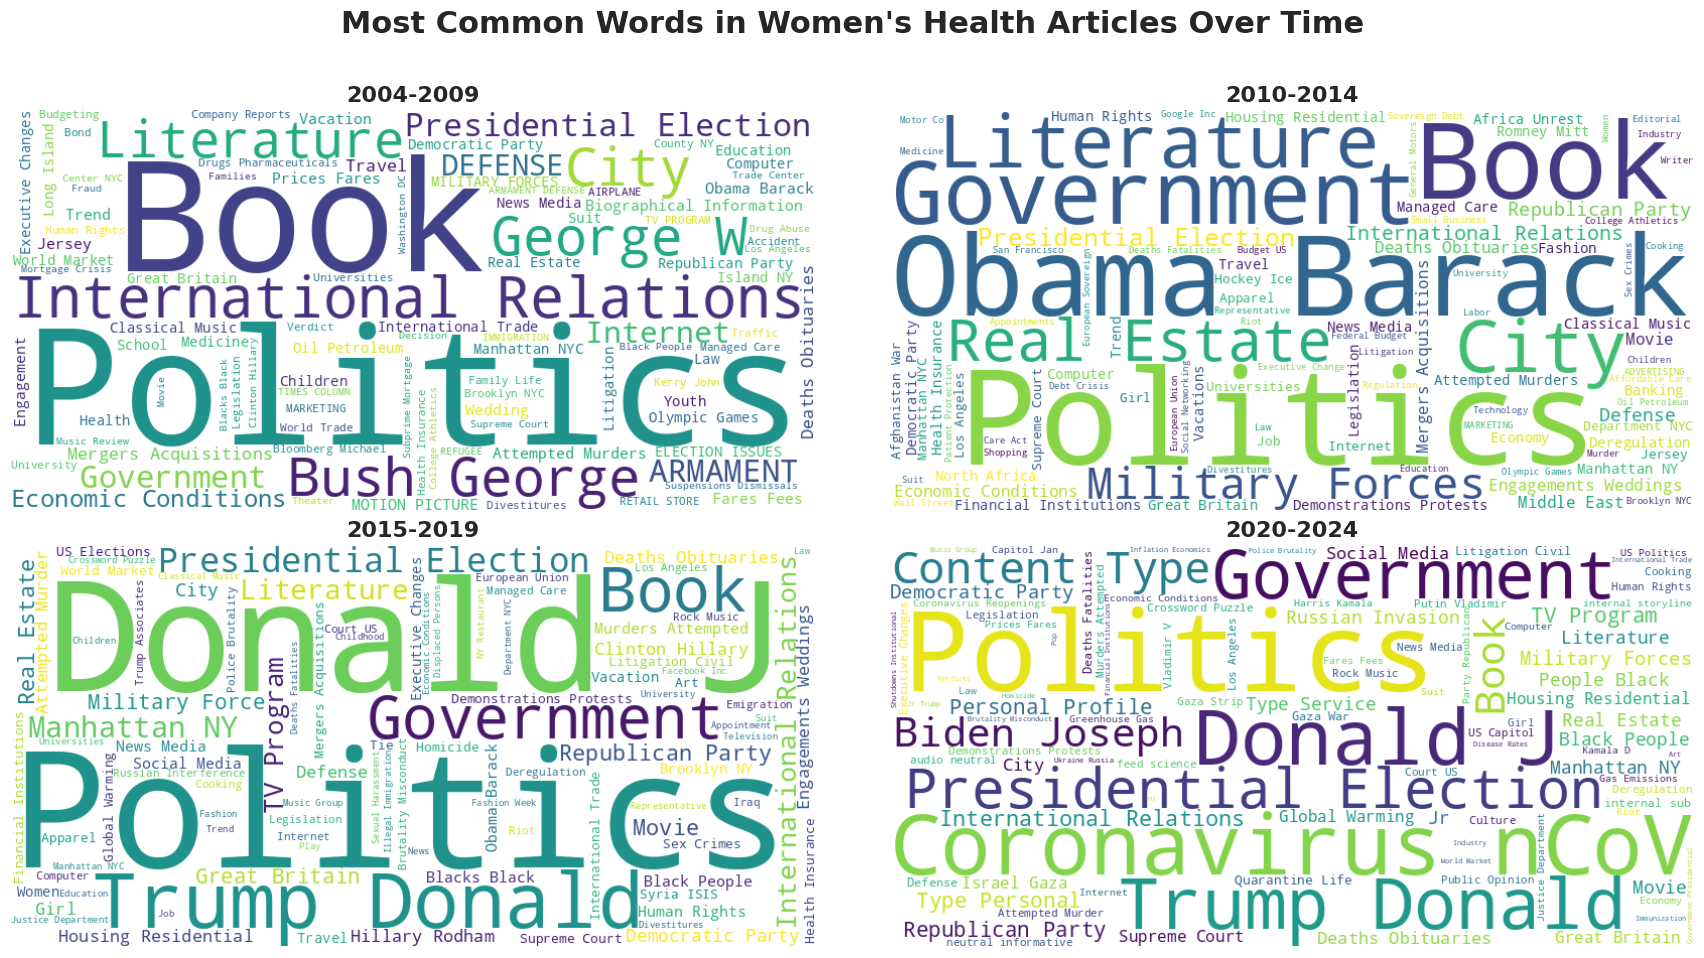

In [ ]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

final_df_model['publication_date'] = pd.to_datetime(final_df_model['year'].astype(str) + '-' + final_df_model['month'].astype(str) + '-01')

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(["say", "said", "will", "new", "one", "york", "s", "year", "day", "nan","united","state","states",])

# Define the 5-year periods and their titles
time_periods = [
    {'start': '2004-01-01', 'end': '2009-12-31', 'title': '2004-2009'},
    {'start': '2010-01-01', 'end': '2014-12-31', 'title': '2010-2014'},
    {'start': '2015-01-01', 'end': '2019-12-31', 'title': '2015-2019'},
    {'start': '2020-01-01', 'end': '2024-12-31', 'title': '2020-2024'}
]

# Create a 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
# Flatten the 2x2 array of axes to make it easier to loop through
axes = axes.flatten()

# --- 3. Generate and Display Word Clouds in a Loop ---
for i, period in enumerate(time_periods):
    # Filter the DataFrame for the current time period
    mask = (final_df_model['publication_date'] >= period['start']) & (final_df_model['publication_date'] <= period['end'])
    period_df = final_df_model.loc[mask]

    # Combine all keywords for this period into a single string
    text = " ".join(period_df['keywords'].astype(str).dropna())

    # Generate the word cloud
    wordcloud = WordCloud(
        stopwords=custom_stopwords,
        background_color="white",
        width=800,
        height=400,
        colormap='viridis',
        max_words=100,
        contour_width=3,
        contour_color='steelblue'
    ).generate(text)

    # Plot the word cloud on the correct subplot
    ax = axes[i]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(period['title'], fontsize=16, fontweight='bold')
    ax.axis("off")

# Add a main title for the entire figure
plt.suptitle('Most Common Words in Women\'s Health Articles Over Time', fontsize=22, fontweight='bold')
plt.tight_layout(pad=3.0)
plt.show()

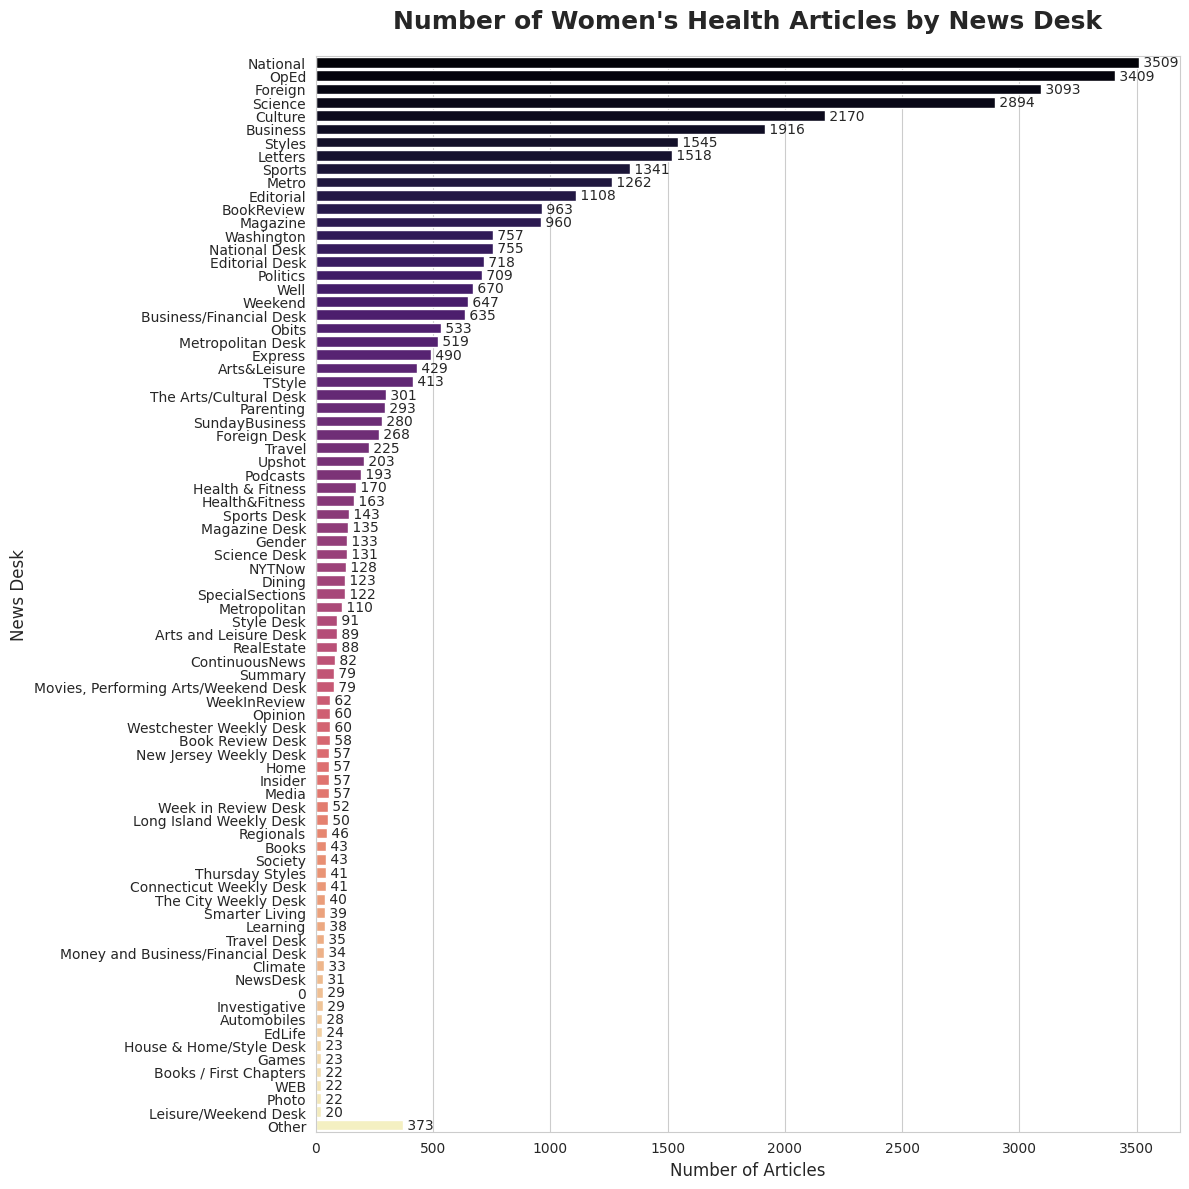

In [ ]:
desk_counts = womens_health_df['news_desk'].value_counts()

top_n = 80
if len(desk_counts) > top_n:
    top_desks = desk_counts.nlargest(top_n)
    other_count = desk_counts.nsmallest(len(desk_counts) - top_n).sum()
    top_desks['Other'] = other_count
    desk_counts_to_plot = top_desks.reset_index()
else:
    desk_counts_to_plot = desk_counts.reset_index()

desk_counts_to_plot.columns = ['news_desk', 'article_count']

# Womens Article in News Desk
plt.figure(figsize=(12, 12))
sns.barplot(x='article_count', y='news_desk', data=desk_counts_to_plot, palette='magma', hue='news_desk')
plt.title('Number of Women\'s Health Articles by News Desk', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('News Desk', fontsize=12)
for index, value in enumerate(desk_counts_to_plot['article_count']):
    plt.text(value, index, f' {value}', va='center')
plt.tight_layout()
plt.show()



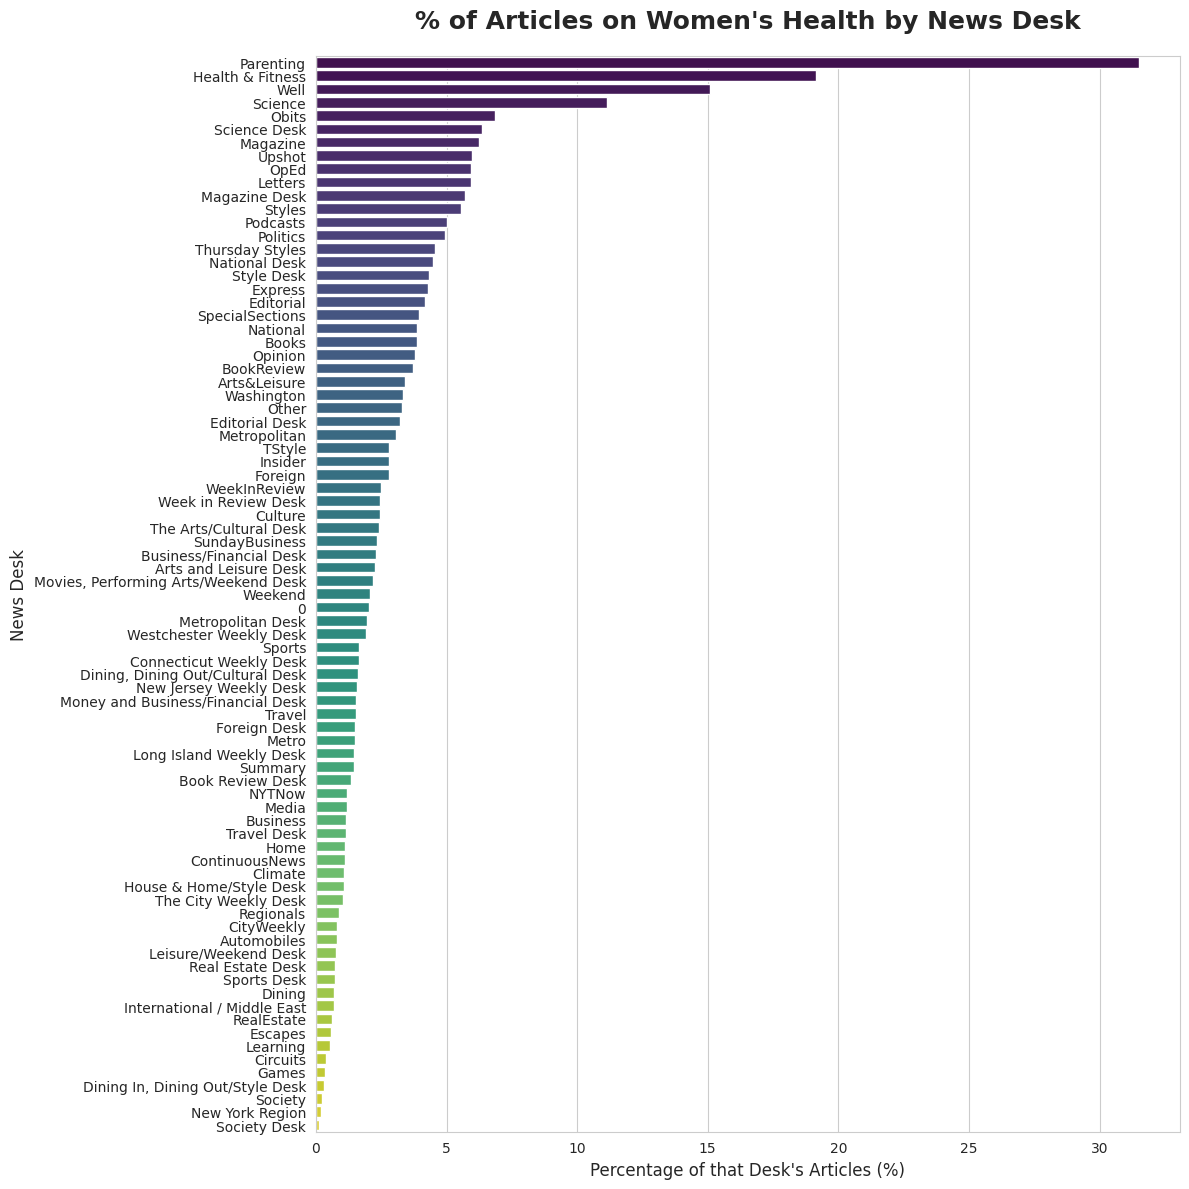

In [ ]:
total_desk_counts = final_df_model['news_desk'].value_counts().reset_index()
total_desk_counts.columns = ['news_desk', 'total_articles']

womens_health_desk_counts = womens_health_df['news_desk'].value_counts().reset_index()
womens_health_desk_counts.columns = ['news_desk', 'womens_health_articles']

desk_summary = pd.merge(total_desk_counts, womens_health_desk_counts, on='news_desk', how='left').fillna(0)
desk_summary['womens_health_articles'] = desk_summary['womens_health_articles'].astype(int)

top_n = 80
desk_summary_to_plot = desk_summary.copy()

if len(desk_summary) > top_n:
    desk_summary_sorted = desk_summary.sort_values(by='total_articles', ascending=False)
    top_desks_df = desk_summary_sorted.nlargest(top_n, 'total_articles')
    other_desks_df = desk_summary_sorted.nsmallest(len(desk_summary) - top_n, 'total_articles')
    if not other_desks_df.empty:
        other_total = other_desks_df['total_articles'].sum()
        other_wh_total = other_desks_df['womens_health_articles'].sum()
        other_row = pd.DataFrame({
            'news_desk': ['Other'],
            'total_articles': [other_total],
            'womens_health_articles': [other_wh_total]
        })
        desk_summary_to_plot = pd.concat([top_desks_df, other_row], ignore_index=True)

desk_summary_to_plot['percentage_womens_health'] = (desk_summary_to_plot['womens_health_articles'] / desk_summary_to_plot['total_articles']) * 100
desk_summary_to_plot = desk_summary_to_plot.sort_values(by='percentage_womens_health', ascending=False)

#% of Women's Health Articles per Desk
plt.figure(figsize=(12, 12))
sns.barplot(x='percentage_womens_health', y='news_desk', data=desk_summary_to_plot, palette='viridis',hue='news_desk')
plt.title('% of Articles on Women\'s Health by News Desk', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Percentage of that Desk\'s Articles (%)', fontsize=12)
plt.ylabel('News Desk', fontsize=12)
plt.tight_layout()
plt.show()



# Adding Themes for Women's Health Article via API


In [43]:
# Import back the full data set for Women's health

from google.colab import drive
import pandas as pd
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/capstone_classified_model.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
#df.head(2)
DF = df.copy()
DF.head(4)


,year,month,headline,lead_paragraph,news_desk,keywords,concatenate,is_womens_health_pred,confidence_score
0,2004,1,FreeMarkets Agrees to Buy Auction Unit of Covi...,"FreeMarkets, which makes Internet-auction soft...",Business/Financial Desk,"General Motors Corp, Ford Motor Co, DaimlerChr...",FreeMarkets Agrees to Buy Auction Unit of Covi...,0,0.043987
1,2004,1,National Briefing | South: Arkansas: Assembly ...,Both houses of the General Assembly recessed u...,National Desk,NaN,National Briefing | South: Arkansas: Assembly ...,0,0.072049
2,2004,1,Clark Courts Veterans in Swing Through South,Winding up several days of campaigning in the ...,National Desk,"Southern States (US), Health Insurance and Man...",Clark Courts Veterans in Swing Through South W...,0,0.324667
3,2004,1,The Time We Thought We Knew,"It was an unlikely place to be at 4:30 a.m., s...",Editorial Desk,"Newton, Isaac, Einstein, Albert, Time, RELATIV...",The Time We Thought We Knew It was an unlikely...,0,0.063922


In [71]:
# 1. Install the Anthropic SDK
# !pip install anthropic

# 2. Set the environment variable for authentication
import os
os.environ['ANTHROPIC_API_KEY'] = "ANTHROPIC_API_KEY"
import pandas as pd
import time
from datetime import datetime
from tqdm import tqdm
from anthropic import Anthropic
from concurrent.futures import ThreadPoolExecutor, as_completed
import threading

# CONFIGURATION - Used to run some tests first

TEST_SAMPLE_SIZE = None  # Set to XX for testing, None for full dataset
CHECKPOINT_INTERVAL = 500  # Save progress every N articles
MAX_WORKERS = 10  # Number of parallel threads
BATCH_SIZE = 50  # Process articles in batches


# --- Constants ---
MODEL_NAME = "claude-3-5-haiku-20241022"
THEMES = [
    "Reproductive Health & Gynecology",
    "Pregnancy & Maternal Health",
    "Breast Cancer",
    "Menstruation & Menopause",
    "Women's Physical Health",
    "Mental Health",
    "Body Image & Eating Disorders",
    "Healthcare System & Women in Medicine",
    "Reproductive Rights & Abortion",
    "Women's Rights & Gender Equality",
    "Violence & Safety",
    "Women in Politics & Leadership",
    "Women in Business & STEM",
    "Work & Economic Issues",
    "Parenting & Motherhood",
    "Women in Sports & Athletics",
    "Women in Arts, Media & Entertainment",
    "Gender & Society",
    "Other Women-Related",
    "Not Women-Related"
]

def get_theme_from_claude(article_text, client):
    """
    Uses Claude API to classify the given article text.
    Optimized for parallel processing with minimal retries.
    """
    if not article_text or pd.isna(article_text):
        return "No Content"

    # Truncate very long articles
    max_chars = 3000
    if len(article_text) > max_chars:
        article_text = article_text[:max_chars] + "..."

    # Create the prompt
    prompt = f"""Classify this article into ONE theme from the following list:

{', '.join(THEMES)}

Respond with ONLY the theme name, nothing else.

Article: "{article_text}"

Theme:"""

    try:
        response = client.messages.create(
            model=MODEL_NAME,
            max_tokens=50,
            temperature=0,
            messages=[
                {"role": "user", "content": prompt}
            ]
        )

        theme = response.content[0].text.strip()

        # Quick validation
        if theme in THEMES:
            return theme

        # Case-insensitive match
        theme_lower = theme.lower()
        for valid_theme in THEMES:
            if valid_theme.lower() == theme_lower:
                return valid_theme

        # Handle "Other" variations
        if theme_lower in ['other', 'other women-related', 'not women-related']:
            if 'not' in theme_lower:
                return "Not Women-Related"
            return "Other Women-Related"

        # Default to Other for unrecognized themes
        return "Other Women-Related"

    except Exception as e:
        error_msg = str(e).lower()

        if "rate" in error_msg or "429" in error_msg:
            return "Rate Limit Error"
        elif "overloaded" in error_msg or "529" in error_msg:
            return "API Overloaded"
        else:
            return "API Error"

def classify_article(row_data, client):
    """
    Classify a single article. Used for parallel processing.
    Returns: (row_idx, theme)
    """
    row_idx, text = row_data
    theme = get_theme_from_claude(text, client)
    return (row_idx, theme)

def main():
    """Main function to run the article classification process."""

        if TEST_SAMPLE_SIZE is not None:
        print(f"CLAUDE CLASSIFICATION - TEST MODE ({TEST_SAMPLE_SIZE:,} articles)")
    else:
        print("CLAUDE CLASSIFICATION - FULL DATASET")
    print("=" * 70)
    print(f"⚡ PARALLEL PROCESSING ENABLED - {MAX_WORKERS} concurrent threads")
    print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

    api_key = os.environ.get('ANTHROPIC_API_KEY')
    if not api_key:
        print("Error: ANTHROPIC_API_KEY environment variable not found.")
        return

    # Initialize the Claude client
    try:
        client = Anthropic(api_key=api_key)

        # Test the client
        print("✓ Testing API connection...")
        test_response = client.messages.create(
            model=MODEL_NAME,
            max_tokens=20,
            messages=[{"role": "user", "content": "Say 'API is working'"}]
        )
        print(f"✓ API test successful! Response: {test_response.content[0].text}\n")

    except Exception as e:
        print(f"✗ Error initializing or testing Claude client: {e}")
        return

    # 1. Load the dataset from the existing DataFrame 'DF'
    try:
        df = globals().get('DF')
        if df is None:
             print("✗ The DataFrame 'DF' was not found in the environment. EXITING.")
             return
        print(f"✓ Successfully loaded {len(df):,} rows from the 'DF' DataFrame.")
    except Exception as e:
        print(f"✗ Error loading DataFrame DF: {e}. EXITING.")
        return

    # 2. Filter for women's health articles
    df['is_womens_health_pred'] = df['is_womens_health_pred'].astype(int)
    df_wh = df[df['is_womens_health_pred'] == 1].copy()

    print(f"✓ Found {len(df_wh):,} articles classified as women's health.\n")

    if len(df_wh) == 0:
        print("✗ Filter resulted in ZERO articles. EXITING.")
        return

    # 3. TESTING MODE
    if TEST_SAMPLE_SIZE is not None:
        print(f"🧪 TEST MODE: Processing {TEST_SAMPLE_SIZE:,} articles")
        print(f"   (Set TEST_SAMPLE_SIZE = None for full run)\n")
        sample_df = df_wh.sample(n=min(TEST_SAMPLE_SIZE, len(df_wh)), random_state=42).copy()
    else:
        print(f"✓ FULL MODE: Processing ALL {len(df_wh):,} articles\n")
        sample_df = df_wh.copy()

    # Add an index column
    if 'article_id' not in sample_df.columns:
        sample_df.reset_index(drop=True, inplace=True)
        sample_df['article_id'] = sample_df.index

    print(f"✓ Processing {len(sample_df):,} articles.\n")

    # Estimate
    estimated_time_minutes = len(sample_df) * 0.5 / MAX_WORKERS / 60
    if estimated_time_minutes < 60:
        print(f"⏱️  Estimated completion time: {estimated_time_minutes:.1f} minutes")
    else:
        print(f"⏱️  Estimated completion time: {estimated_time_minutes/60:.1f} hours")
    print(f"   (parallel processing with {MAX_WORKERS} threads)\n")

    # 4. Checkpoint files
    if TEST_SAMPLE_SIZE is not None:
        checkpoint_file = '/content/drive/My Drive/checkpoint_themes_CLAUDE_TEST.csv'
        output_path = '/content/drive/My Drive/capstone_themes_CLAUDE_TEST.csv'
    else:
        checkpoint_file = '/content/drive/My Drive/checkpoint_themes_CLAUDE_FULL.csv'
        output_path = '/content/drive/My Drive/capstone_themes_CLAUDE_FULL.csv'

    # Load checkpoint if exists
    if os.path.exists(checkpoint_file):
        print(f"📋 Found existing checkpoint file. Loading...")
        try:
            checkpoint_df = pd.read_csv(checkpoint_file)

            if 'article_id' in checkpoint_df.columns:
                merge_on = 'article_id'
            else:
                checkpoint_df.reset_index(drop=True, inplace=True)
                checkpoint_df['article_id'] = checkpoint_df.index
                merge_on = 'article_id'

            sample_df = sample_df.merge(
                checkpoint_df[[merge_on, 'claude_theme']],
                on=merge_on,
                how='left',
                suffixes=('', '_checkpoint')
            )
            already_classified = sample_df['claude_theme_checkpoint'].notna()
            classified_count = already_classified.sum()

            if classified_count > 0:
                print(f"✓ Resuming: {classified_count:,} articles already classified")
                sample_df.loc[already_classified, 'claude_theme'] = sample_df.loc[already_classified, 'claude_theme_checkpoint']
                sample_df = sample_df.drop('claude_theme_checkpoint', axis=1)
            else:
                print("✓ Checkpoint loaded but no previous classifications found")
                if 'claude_theme_checkpoint' in sample_df.columns:
                    sample_df = sample_df.drop('claude_theme_checkpoint', axis=1)
        except Exception as e:
            print(f"⚠️  Warning: Could not load checkpoint: {e}")
    else:
        print(f"📋 No checkpoint found. Starting fresh...\n")

    # Initialize column
    if 'claude_theme' not in sample_df.columns:
        sample_df['claude_theme'] = None

    # 5. Classification
    if 'concatenate' not in sample_df.columns:
        print("✗ 'concatenate' column not found. EXITING.")
        return

    print("=" * 70)
    print("STARTING PARALLEL CLASSIFICATION")
    print("=" * 70)
    print(f"Model: {MODEL_NAME}")
    print(f"Concurrent threads: {MAX_WORKERS}")
    print(f"Checkpoint interval: every {CHECKPOINT_INTERVAL} articles")
    print(f"Batch size: {BATCH_SIZE} articles\n")

    start_time = time.time()
    total_processed = 0
    error_counts = {
        'API Error': 0,
        'Rate Limit Error': 0,
        'API Overloaded': 0
    }

    needs_classification = sample_df['claude_theme'].isna()
    items_to_process = sample_df[needs_classification]

    print(f"Articles to process: {len(items_to_process):,}\n")

    if len(items_to_process) == 0:
        print("✓ All articles already classified!")
    else:
        processing_data = [(idx, row['concatenate']) for idx, row in items_to_process.iterrows()]

        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            with tqdm(total=len(processing_data), desc="Classifying", unit="articles") as pbar:

                for batch_start in range(0, len(processing_data), BATCH_SIZE):
                    batch_end = min(batch_start + BATCH_SIZE, len(processing_data))
                    batch_data = processing_data[batch_start:batch_end]

                    future_to_data = {
                        executor.submit(classify_article, data, client): data
                        for data in batch_data
                    }

                    for future in as_completed(future_to_data):
                        try:
                            row_idx, theme = future.result()
                            sample_df.at[row_idx, 'claude_theme'] = theme

                            total_processed += 1

                            for error_type in error_counts.keys():
                                if error_type in theme:
                                    error_counts[error_type] += 1

                            pbar.update(1)

                        except Exception as e:
                            print(f"\n⚠️  Error: {e}")
                            total_processed += 1
                            pbar.update(1)

                    # Checkpoint save
                    if total_processed % CHECKPOINT_INTERVAL < BATCH_SIZE:
                        try:
                            sample_df.to_csv(checkpoint_file, index=False)
                            elapsed = time.time() - start_time
                            rate = total_processed / elapsed if elapsed > 0 else 0
                            remaining = len(items_to_process) - total_processed
                            eta_minutes = (remaining / rate / 60) if rate > 0 else 0

                            print(f"\n💾 [{total_processed:,}/{len(items_to_process):,}] "
                                  f"Rate: {rate:.2f}/s | ETA: {eta_minutes:.1f}m | "
                                  f"Errors: {sum(error_counts.values())}")
                        except Exception as e:
                            print(f"\n⚠️  Checkpoint save failed: {e}")

    print("\n" + "=" * 70)
    print("CLASSIFICATION COMPLETE")
    print("=" * 70)

    elapsed_time = time.time() - start_time
    elapsed_minutes = elapsed_time / 60

    if elapsed_minutes < 60:
        print(f"\n⏱️  Total time: {elapsed_minutes:.1f} minutes")
    else:
        print(f"\n⏱️  Total time: {elapsed_minutes/60:.2f} hours")

    if total_processed > 0:
        print(f"📊 Articles processed: {total_processed:,}")
        print(f"⚡ Average rate: {total_processed / elapsed_time:.2f} articles/sec\n")

    # 6. Save results
    try:
        sample_df.to_csv(output_path, index=False)
        print(f"✅ SUCCESS! Results saved to:\n   {output_path}\n")

        if os.path.exists(checkpoint_file):
            os.remove(checkpoint_file)
            print(f"🗑️  Checkpoint file removed\n")
    except Exception as e:
        print(f"✗ Could not save: {e}")
        print(f"   Data in checkpoint: {checkpoint_file}\n")

    # 7. Results summary
    print("=" * 70)
    print("THEME DISTRIBUTION")
    print("=" * 70)

    theme_counts = sample_df['claude_theme'].value_counts()

    error_keywords = ['Error', 'Overloaded']
    error_themes = theme_counts[theme_counts.index.str.contains('|'.join(error_keywords), na=False)]
    valid_themes = theme_counts[~theme_counts.index.str.contains('|'.join(error_keywords), na=False)]

    print("\n📈 Valid Classifications:")
    for theme, count in valid_themes.head(15).items():
        percentage = (count / len(sample_df)) * 100
        print(f"   {theme}: {count:,} ({percentage:.1f}%)")

    if len(valid_themes) > 15:
        print(f"   ... and {len(valid_themes) - 15} more themes")

    if len(error_themes) > 0:
        print("\n❌ Errors:")
        for theme, count in error_themes.items():
            percentage = (count / len(sample_df)) * 100
            print(f"   {theme}: {count:,} ({percentage:.1f}%)")

        total_errors = error_themes.sum()
        error_rate = (total_errors / len(sample_df)) * 100
        print(f"\n⚠️  Total errors: {total_errors:,} ({error_rate:.2f}%)")
    else:
        print("\n✅ No errors!")

    print("\n" + "=" * 70)
    if TEST_SAMPLE_SIZE is not None:
        print("TEST RUN COMPLETE")
        print("To run full dataset, set TEST_SAMPLE_SIZE = None")
    else:
        print("FULL RUN COMPLETE")
    print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("=" * 70)


if __name__ == '__main__':
    main()

CLAUDE CLASSIFICATION - FULL DATASET
⚡ PARALLEL PROCESSING ENABLED - 10 concurrent threads
Start time: 2025-10-05 22:16:39

✓ Claude API client initialized successfully.
✓ Testing API connection...
✓ API test successful! Response: API is working

✓ Successfully loaded 1,594,727 rows from the 'DF' DataFrame.
✓ Found 42,801 articles classified as women's health.

✓ FULL MODE: Processing ALL 42,801 articles

✓ Processing 42,801 articles.

⏱️  Estimated completion time: 35.7 minutes
   (parallel processing with 10 threads)

📋 No checkpoint found. Starting fresh...

STARTING PARALLEL CLASSIFICATION
Model: claude-3-5-haiku-20241022
Concurrent threads: 10
Checkpoint interval: every 500 articles
Batch size: 50 articles

Articles to process: 42,801



Classifying:   1%|          | 500/42801 [02:02<17:30:17,  1.49s/articles]


💾 [500/42,801] Rate: 3.86/s | ETA: 182.7m | Errors: 0


Classifying:   2%|▏         | 1000/42801 [03:50<6:46:30,  1.71articles/s]


💾 [1,000/42,801] Rate: 4.22/s | ETA: 165.1m | Errors: 0


Classifying:   4%|▎         | 1500/42801 [05:47<7:02:33,  1.63articles/s]


💾 [1,500/42,801] Rate: 4.22/s | ETA: 163.0m | Errors: 0


Classifying:   5%|▍         | 2000/42801 [08:23<34:25:10,  3.04s/articles]


💾 [2,000/42,801] Rate: 3.92/s | ETA: 173.6m | Errors: 0


Classifying:   6%|▌         | 2500/42801 [10:35<11:00:16,  1.02articles/s]


💾 [2,500/42,801] Rate: 3.89/s | ETA: 172.5m | Errors: 0


Classifying:   7%|▋         | 2999/42801 [11:44<49:39, 13.36articles/s]


💾 [3,000/42,801] Rate: 4.21/s | ETA: 157.5m | Errors: 0


Classifying:   8%|▊         | 3500/42801 [12:43<1:44:46,  6.25articles/s]


💾 [3,500/42,801] Rate: 4.54/s | ETA: 144.2m | Errors: 15


Classifying:   9%|▉         | 4000/42801 [14:03<1:39:30,  6.50articles/s]


💾 [4,000/42,801] Rate: 4.70/s | ETA: 137.5m | Errors: 50


Classifying:  11%|█         | 4500/42801 [15:28<2:17:17,  4.65articles/s]


💾 [4,500/42,801] Rate: 4.81/s | ETA: 132.7m | Errors: 68


Classifying:  12%|█▏        | 5000/42801 [18:03<3:15:36,  3.22articles/s]


💾 [5,000/42,801] Rate: 4.59/s | ETA: 137.4m | Errors: 68


Classifying:  13%|█▎        | 5500/42801 [20:14<10:24:21,  1.00s/articles]


💾 [5,500/42,801] Rate: 4.50/s | ETA: 138.2m | Errors: 68


Classifying:  14%|█▍        | 6000/42801 [23:00<3:08:01,  3.26articles/s]


💾 [6,000/42,801] Rate: 4.32/s | ETA: 141.9m | Errors: 68


Classifying:  15%|█▌        | 6499/42801 [24:39<1:46:02,  5.71articles/s]


💾 [6,500/42,801] Rate: 4.36/s | ETA: 138.7m | Errors: 68


Classifying:  16%|█▋        | 7000/42801 [26:59<63:39:19,  6.40s/articles]


💾 [7,000/42,801] Rate: 4.30/s | ETA: 138.7m | Errors: 68


Classifying:  18%|█▊        | 7500/42801 [29:24<15:59:00,  1.63s/articles]


💾 [7,500/42,801] Rate: 4.23/s | ETA: 139.0m | Errors: 68


Classifying:  19%|█▊        | 8000/42801 [31:28<1:30:10,  6.43articles/s]


💾 [8,000/42,801] Rate: 4.22/s | ETA: 137.4m | Errors: 68


Classifying:  20%|█▉        | 8500/42801 [33:41<1:48:19,  5.28articles/s]


💾 [8,500/42,801] Rate: 4.19/s | ETA: 136.4m | Errors: 68


Classifying:  21%|██        | 9000/42801 [36:43<41:53:16,  4.46s/articles]


💾 [9,000/42,801] Rate: 4.07/s | ETA: 138.4m | Errors: 68


Classifying:  22%|██▏       | 9500/42801 [39:45<18:46:02,  2.03s/articles]


💾 [9,500/42,801] Rate: 3.97/s | ETA: 139.8m | Errors: 68


Classifying:  23%|██▎       | 10000/42801 [41:59<7:07:57,  1.28articles/s]


💾 [10,000/42,801] Rate: 3.96/s | ETA: 138.1m | Errors: 68


Classifying:  25%|██▍       | 10500/42801 [43:33<4:00:25,  2.24articles/s]


💾 [10,500/42,801] Rate: 4.01/s | ETA: 134.4m | Errors: 179


Classifying:  26%|██▌       | 11000/42801 [45:20<2:34:38,  3.43articles/s]


💾 [11,000/42,801] Rate: 4.03/s | ETA: 131.4m | Errors: 329


Classifying:  27%|██▋       | 11500/42801 [46:49<12:31:33,  1.44s/articles]


💾 [11,500/42,801] Rate: 4.08/s | ETA: 127.8m | Errors: 350


Classifying:  28%|██▊       | 12000/42801 [48:04<4:13:07,  2.03articles/s]


💾 [12,000/42,801] Rate: 4.15/s | ETA: 123.8m | Errors: 358


Classifying:  29%|██▉       | 12500/42801 [50:04<1:42:18,  4.94articles/s]


💾 [12,500/42,801] Rate: 4.15/s | ETA: 121.6m | Errors: 359


Classifying:  30%|███       | 13000/42801 [52:26<9:16:10,  1.12s/articles] 


💾 [13,000/42,801] Rate: 4.12/s | ETA: 120.5m | Errors: 359


Classifying:  32%|███▏      | 13500/42801 [54:44<14:54:43,  1.83s/articles]


💾 [13,500/42,801] Rate: 4.10/s | ETA: 119.1m | Errors: 359


Classifying:  33%|███▎      | 14000/42801 [57:16<12:43:36,  1.59s/articles]


💾 [14,000/42,801] Rate: 4.07/s | ETA: 118.1m | Errors: 359


Classifying:  34%|███▍      | 14500/42801 [59:23<3:49:27,  2.06articles/s]


💾 [14,500/42,801] Rate: 4.06/s | ETA: 116.1m | Errors: 359


Classifying:  35%|███▌      | 15000/42801 [1:02:22<4:56:46,  1.56articles/s]


💾 [15,000/42,801] Rate: 4.00/s | ETA: 115.8m | Errors: 359


Classifying:  36%|███▌      | 15499/42801 [1:04:37<41:01, 11.09articles/s]


💾 [15,500/42,801] Rate: 3.99/s | ETA: 114.1m | Errors: 359


Classifying:  37%|███▋      | 16000/42801 [1:06:49<3:47:30,  1.96articles/s]


💾 [16,000/42,801] Rate: 3.98/s | ETA: 112.1m | Errors: 359


Classifying:  39%|███▊      | 16500/42801 [1:09:06<3:52:45,  1.88articles/s]


💾 [16,500/42,801] Rate: 3.97/s | ETA: 110.3m | Errors: 359


Classifying:  40%|███▉      | 17000/42801 [1:12:08<6:18:33,  1.14articles/s]


💾 [17,000/42,801] Rate: 3.92/s | ETA: 109.7m | Errors: 359


Classifying:  41%|████      | 17500/42801 [1:14:30<4:19:50,  1.62articles/s]


💾 [17,500/42,801] Rate: 3.91/s | ETA: 107.9m | Errors: 359


Classifying:  42%|████▏     | 18000/42801 [1:17:13<10:07:44,  1.47s/articles]


💾 [18,000/42,801] Rate: 3.88/s | ETA: 106.6m | Errors: 359


Classifying:  43%|████▎     | 18499/42801 [1:19:09<36:41, 11.04articles/s]


💾 [18,500/42,801] Rate: 3.89/s | ETA: 104.1m | Errors: 359


Classifying:  44%|████▍     | 19000/42801 [1:20:58<22:52:52,  3.46s/articles]


💾 [19,000/42,801] Rate: 3.91/s | ETA: 101.6m | Errors: 359


Classifying:  46%|████▌     | 19500/42801 [1:23:46<10:47:29,  1.67s/articles]


💾 [19,500/42,801] Rate: 3.87/s | ETA: 100.2m | Errors: 359


Classifying:  47%|████▋     | 20000/42801 [1:26:16<7:47:46,  1.23s/articles]


💾 [20,000/42,801] Rate: 3.86/s | ETA: 98.5m | Errors: 359


Classifying:  48%|████▊     | 20500/42801 [1:28:48<57:24,  6.48articles/s]


💾 [20,500/42,801] Rate: 3.84/s | ETA: 96.7m | Errors: 359


Classifying:  49%|████▉     | 20999/42801 [1:30:11<36:49,  9.87articles/s]


💾 [21,000/42,801] Rate: 3.88/s | ETA: 93.8m | Errors: 359


Classifying:  50%|█████     | 21500/42801 [1:31:58<4:55:45,  1.20articles/s]


💾 [21,500/42,801] Rate: 3.89/s | ETA: 91.2m | Errors: 359


Classifying:  51%|█████▏    | 22000/42801 [1:33:40<7:36:09,  1.32s/articles]


💾 [22,000/42,801] Rate: 3.91/s | ETA: 88.7m | Errors: 359


Classifying:  53%|█████▎    | 22500/42801 [1:35:44<4:42:13,  1.20articles/s]


💾 [22,500/42,801] Rate: 3.91/s | ETA: 86.5m | Errors: 359


Classifying:  54%|█████▎    | 23000/42801 [1:37:19<7:00:19,  1.27s/articles]


💾 [23,000/42,801] Rate: 3.93/s | ETA: 83.9m | Errors: 359


Classifying:  55%|█████▍    | 23499/42801 [1:39:40<31:56, 10.07articles/s]


💾 [23,500/42,801] Rate: 3.92/s | ETA: 82.0m | Errors: 359


Classifying:  56%|█████▌    | 23999/42801 [1:41:40<34:37,  9.05articles/s]


💾 [24,000/42,801] Rate: 3.93/s | ETA: 79.7m | Errors: 359


Classifying:  57%|█████▋    | 24500/42801 [1:44:02<10:47:03,  2.12s/articles]


💾 [24,500/42,801] Rate: 3.92/s | ETA: 77.8m | Errors: 359


Classifying:  58%|█████▊    | 24999/42801 [1:46:26<2:51:58,  1.73articles/s]


💾 [25,000/42,801] Rate: 3.91/s | ETA: 75.9m | Errors: 359


Classifying:  60%|█████▉    | 25499/42801 [1:48:08<29:39,  9.72articles/s]


💾 [25,500/42,801] Rate: 3.93/s | ETA: 73.5m | Errors: 359


Classifying:  61%|██████    | 25999/42801 [1:50:07<23:40, 11.83articles/s]


💾 [26,000/42,801] Rate: 3.93/s | ETA: 71.2m | Errors: 359


Classifying:  62%|██████▏   | 26499/42801 [1:50:53<22:07, 12.28articles/s]


💾 [26,500/42,801] Rate: 3.98/s | ETA: 68.3m | Errors: 359


Classifying:  63%|██████▎   | 27000/42801 [1:52:15<2:39:31,  1.65articles/s]


💾 [27,000/42,801] Rate: 4.00/s | ETA: 65.8m | Errors: 370


Classifying:  64%|██████▍   | 27500/42801 [1:54:14<5:27:44,  1.29s/articles]


💾 [27,500/42,801] Rate: 4.01/s | ETA: 63.6m | Errors: 370


Classifying:  65%|██████▌   | 27999/42801 [1:56:02<1:54:17,  2.16articles/s]


💾 [28,000/42,801] Rate: 4.02/s | ETA: 61.4m | Errors: 370


Classifying:  67%|██████▋   | 28500/42801 [1:57:48<1:36:02,  2.48articles/s]


💾 [28,500/42,801] Rate: 4.03/s | ETA: 59.2m | Errors: 370


Classifying:  68%|██████▊   | 29000/42801 [1:59:38<4:00:29,  1.05s/articles]


💾 [29,000/42,801] Rate: 4.04/s | ETA: 57.0m | Errors: 370


Classifying:  69%|██████▉   | 29500/42801 [2:01:32<1:20:14,  2.76articles/s]


💾 [29,500/42,801] Rate: 4.04/s | ETA: 54.9m | Errors: 370


Classifying:  70%|███████   | 30000/42801 [2:03:22<2:01:39,  1.75articles/s]


💾 [30,000/42,801] Rate: 4.05/s | ETA: 52.7m | Errors: 370


Classifying:  71%|███████▏  | 30500/42801 [2:05:35<1:55:10,  1.78articles/s]


💾 [30,500/42,801] Rate: 4.04/s | ETA: 50.7m | Errors: 370


Classifying:  72%|███████▏  | 31000/42801 [2:07:54<29:23,  6.69articles/s]


💾 [31,000/42,801] Rate: 4.04/s | ETA: 48.7m | Errors: 370


Classifying:  74%|███████▎  | 31500/42801 [2:10:26<5:44:43,  1.83s/articles]


💾 [31,500/42,801] Rate: 4.02/s | ETA: 46.8m | Errors: 370


Classifying:  75%|███████▍  | 31999/42801 [2:12:25<18:21,  9.81articles/s]


💾 [32,000/42,801] Rate: 4.02/s | ETA: 44.7m | Errors: 370


Classifying:  76%|███████▌  | 32500/42801 [2:14:31<1:49:34,  1.57articles/s]


💾 [32,500/42,801] Rate: 4.02/s | ETA: 42.7m | Errors: 370


Classifying:  77%|███████▋  | 33000/42801 [2:16:38<4:10:58,  1.54s/articles]


💾 [33,000/42,801] Rate: 4.02/s | ETA: 40.6m | Errors: 370


Classifying:  78%|███████▊  | 33500/42801 [2:18:28<1:36:22,  1.61articles/s]


💾 [33,500/42,801] Rate: 4.03/s | ETA: 38.5m | Errors: 370


Classifying:  79%|███████▉  | 34000/42801 [2:20:03<29:46,  4.93articles/s]


💾 [34,000/42,801] Rate: 4.04/s | ETA: 36.3m | Errors: 370


Classifying:  81%|████████  | 34500/42801 [2:21:44<28:51,  4.79articles/s]


💾 [34,500/42,801] Rate: 4.05/s | ETA: 34.1m | Errors: 370


Classifying:  82%|████████▏ | 35000/42801 [2:24:02<36:06,  3.60articles/s]


💾 [35,000/42,801] Rate: 4.05/s | ETA: 32.1m | Errors: 370


Classifying:  83%|████████▎ | 35499/42801 [2:25:41<08:33, 14.22articles/s]


💾 [35,500/42,801] Rate: 4.06/s | ETA: 30.0m | Errors: 370


Classifying:  84%|████████▍ | 36000/42801 [2:27:50<1:09:47,  1.62articles/s]


💾 [36,000/42,801] Rate: 4.06/s | ETA: 28.0m | Errors: 370


Classifying:  85%|████████▌ | 36499/42801 [2:29:29<06:44, 15.60articles/s]


💾 [36,500/42,801] Rate: 4.07/s | ETA: 25.8m | Errors: 370


Classifying:  86%|████████▋ | 36999/42801 [2:31:34<55:34,  1.74articles/s]  


💾 [37,000/42,801] Rate: 4.07/s | ETA: 23.8m | Errors: 370


Classifying:  88%|████████▊ | 37500/42801 [2:34:01<54:03,  1.63articles/s]  


💾 [37,500/42,801] Rate: 4.05/s | ETA: 21.8m | Errors: 370


Classifying:  89%|████████▉ | 37999/42801 [2:36:15<08:09,  9.81articles/s]


💾 [38,000/42,801] Rate: 4.05/s | ETA: 19.8m | Errors: 370


Classifying:  90%|████████▉ | 38500/42801 [2:37:57<13:52,  5.17articles/s]


💾 [38,500/42,801] Rate: 4.06/s | ETA: 17.7m | Errors: 370


Classifying:  91%|█████████ | 39000/42801 [2:39:30<19:47,  3.20articles/s]


💾 [39,000/42,801] Rate: 4.07/s | ETA: 15.6m | Errors: 370


Classifying:  92%|█████████▏| 39500/42801 [2:41:23<1:10:18,  1.28s/articles]


💾 [39,500/42,801] Rate: 4.08/s | ETA: 13.5m | Errors: 370


Classifying:  93%|█████████▎| 40000/42801 [2:43:40<1:14:13,  1.59s/articles]


💾 [40,000/42,801] Rate: 4.07/s | ETA: 11.5m | Errors: 370


Classifying:  95%|█████████▍| 40500/42801 [2:45:15<12:10,  3.15articles/s]


💾 [40,500/42,801] Rate: 4.08/s | ETA: 9.4m | Errors: 370


Classifying:  96%|█████████▌| 41000/42801 [2:47:25<1:32:19,  3.08s/articles]


💾 [41,000/42,801] Rate: 4.08/s | ETA: 7.4m | Errors: 370


Classifying:  97%|█████████▋| 41500/42801 [2:49:32<17:57,  1.21articles/s]


💾 [41,500/42,801] Rate: 4.08/s | ETA: 5.3m | Errors: 370


Classifying:  98%|█████████▊| 42000/42801 [2:51:46<45:20,  3.40s/articles]


💾 [42,000/42,801] Rate: 4.07/s | ETA: 3.3m | Errors: 370


Classifying:  99%|█████████▉| 42499/42801 [2:53:07<00:32,  9.35articles/s]


💾 [42,500/42,801] Rate: 4.09/s | ETA: 1.2m | Errors: 370


Classifying: 100%|██████████| 42801/42801 [2:54:12<00:00,  4.09articles/s]



CLASSIFICATION COMPLETE

⏱️  Total time: 2.90 hours
📊 Articles processed: 42,801
⚡ Average rate: 4.09 articles/sec

✅ SUCCESS! Results saved to:
   /content/drive/My Drive/capstone_themes_CLAUDE_FULL.csv

🗑️  Checkpoint file removed

THEME DISTRIBUTION

📈 Valid Classifications:
   Reproductive Rights & Abortion: 5,974 (14.0%)
   Women in Arts, Media & Entertainment: 3,669 (8.6%)
   Women's Rights & Gender Equality: 3,605 (8.4%)
   Not Women-Related: 3,588 (8.4%)
   Pregnancy & Maternal Health: 3,051 (7.1%)
   Violence & Safety: 2,888 (6.7%)
   Women in Politics & Leadership: 2,339 (5.5%)
   Parenting & Motherhood: 2,104 (4.9%)
   Women's Physical Health: 2,087 (4.9%)
   Breast Cancer: 1,833 (4.3%)
   Women in Sports & Athletics: 1,709 (4.0%)
   Women in Business & STEM: 1,551 (3.6%)
   Other Women-Related: 1,546 (3.6%)
   Reproductive Health & Gynecology: 1,490 (3.5%)
   Mental Health: 1,266 (3.0%)
   ... and 5 more themes

❌ Errors:
   Rate Limit Error: 370 (0.9%)

⚠️  Total errors: 

# Analysis Part II: what did we learn with themes?

In [72]:
# If needed, import back the full data set

from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

claude_final = pd.read_csv('/content/drive/MyDrive/capstone_themes_CLAUDE_FULL.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
claude_final.head(1)


,year,month,headline,lead_paragraph,news_desk,keywords,concatenate,is_womens_health_pred,confidence_score,article_id,claude_theme
0,2004,1,Pulp Fiction by Women With Protofeminist Roots,''She didn't know he was there in the high fog...,The Arts/Cultural Desk,"Feminist Press, TAYLOR, VALERIE, BALDWIN, FAIT...",Pulp Fiction by Women With Protofeminist Roots...,1,0.56923,0,"Women in Arts, Media & Entertainment"


In [80]:
print(claude_final['claude_theme'].value_counts())

claude_theme
Reproductive Rights & Abortion           5974
Women in Arts, Media & Entertainment     3669
Women's Rights & Gender Equality         3605
Not Women-Related                        3588
Pregnancy & Maternal Health              3051
Violence & Safety                        2888
Women in Politics & Leadership           2339
Parenting & Motherhood                   2104
Women's Physical Health                  2087
Breast Cancer                            1833
Women in Sports & Athletics              1709
Women in Business & STEM                 1551
Other Women-Related                      1546
Reproductive Health & Gynecology         1490
Mental Health                            1266
Healthcare System & Women in Medicine    1242
Work & Economic Issues                    763
Gender & Society                          759
Body Image & Eating Disorders             613
Rate Limit Error                          370
Menstruation & Menopause                  354
Name: count, dtype: i

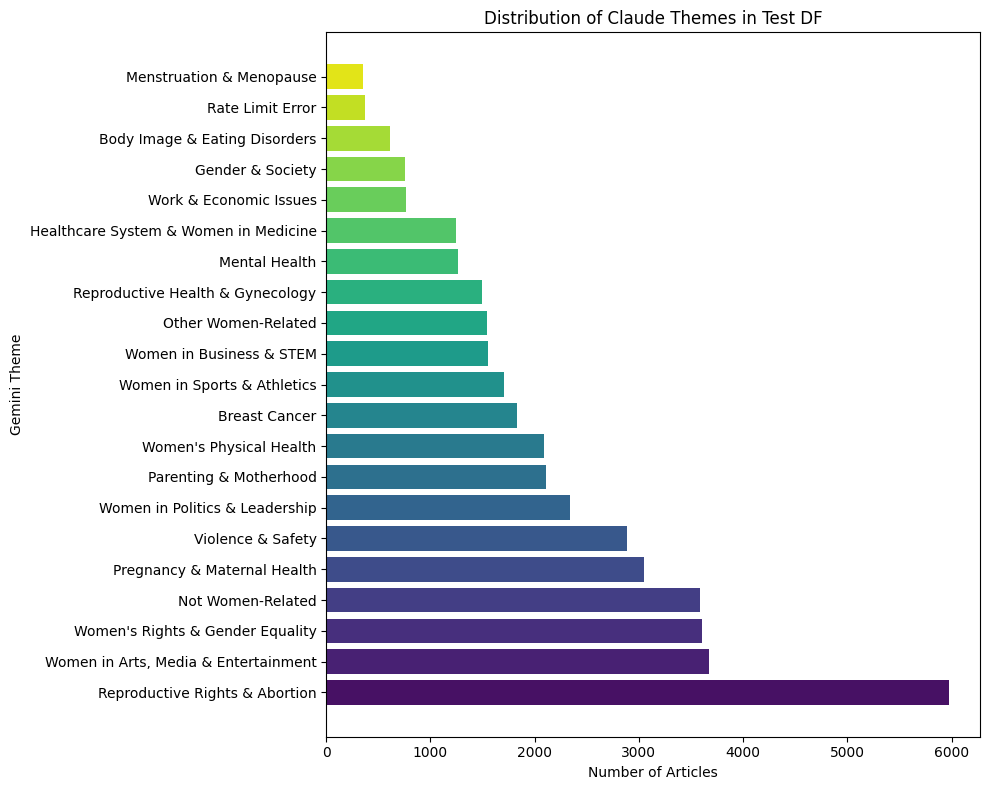

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each theme
theme_counts = claude_final['claude_theme'].value_counts()

# Plot a horizontal bar chart using matplotlib directly
plt.figure(figsize=(10, 8))
plt.barh(theme_counts.index, theme_counts.values, color=sns.color_palette('viridis', len(theme_counts)))
plt.title('Distribution of Claude Themes in Test DF')
plt.xlabel('Number of Articles')
plt.ylabel('Gemini Theme')
plt.tight_layout()
plt.show()

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def filter_data(df):
    """Remove articles with 'rate limit error' or 'not-women's health' themes"""
    original_count = len(df)
    df_filtered = df[~df['claude_theme'].isin(['Rate Limit Error', "Not Women-Related"])].copy()
    removed_count = original_count - len(df_filtered)
    return df_filtered

def plot_theme_distribution(df):
    """Shows the overall distribution of themes"""
    plt.figure(figsize=(12, 8))

    theme_counts = df['claude_theme'].value_counts().sort_values()

    colors = sns.color_palette("viridis", len(theme_counts))
    theme_counts.plot(kind='barh', color=colors)

    plt.title('Distribution of Article Themes', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Number of Articles', fontsize=12)
    plt.ylabel('Theme', fontsize=12)
    plt.tight_layout()

    # Add value labels on bars
    ax = plt.gca()
    for i, v in enumerate(theme_counts):
        ax.text(v + 0.5, i, str(v), va='center', fontsize=10)

    plt.show()

def plot_themes_over_time(df, top_n=5):
    """Shows how top N themes evolved over time as percentage of total articles"""
    # Get top N themes
    top_themes = df['claude_theme'].value_counts().head(top_n).index

    # Get total articles per year
    yearly_totals = df.groupby('year').size().reset_index(name='total')

    # Filter for top themes only
    df_top = df[df['claude_theme'].isin(top_themes)].copy()

    # Group by year and theme
    yearly_themes = df_top.groupby(['year', 'claude_theme']).size().reset_index(name='count')

    # Merge with totals to calculate percentage
    yearly_themes = yearly_themes.merge(yearly_totals, on='year')
    yearly_themes['percentage'] = (yearly_themes['count'] / yearly_themes['total']) * 100

    plt.figure(figsize=(14, 8))

    for theme in top_themes:
        theme_data = yearly_themes[yearly_themes['claude_theme'] == theme]
        plt.plot(theme_data['year'], theme_data['percentage'], marker='o', linewidth=2, label=theme)

    plt.title(f'Top {top_n} Themes Over Time (% of Total Articles)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage of Articles (%)', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_theme_heatmap(df):
    """Creates a heatmap showing theme percentage over years"""
    # Get total articles per year
    yearly_totals = df.groupby('year').size()

    # Create pivot table with counts
    pivot = df.groupby(['year', 'claude_theme']).size().reset_index(name='count')
    pivot_table = pivot.pivot(index='claude_theme', columns='year', values='count').fillna(0)

    # Convert to percentages
    pivot_pct = pivot_table.div(yearly_totals, axis=1) * 100

    plt.figure(figsize=(16, 10))
    sns.heatmap(pivot_pct, cmap='YlOrRd', annot=True, fmt='.1f',
                linewidths=0.5, cbar_kws={'label': 'Percentage of Articles (%)'})

    plt.title('Theme Distribution Across Years (% of Total Articles)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Theme', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_stacked_bar_year(df):
    """Shows theme distribution as 100% stacked bars by year"""
    # Create pivot table with counts
    pivot = df.groupby(['year', 'claude_theme']).size().reset_index(name='count')
    pivot_table = pivot.pivot(index='year', columns='claude_theme', values='count').fillna(0)

    # Convert to percentages
    pivot_pct = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

    # Plot
    ax = pivot_pct.plot(kind='bar', stacked=True, figsize=(16, 8),
                        colormap='tab20', width=0.8)

    plt.title('Theme Distribution by Year (100% Stacked)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage of Articles (%)', fontsize=12)
    plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def plot_stacked_bar_year_month(df):
    """Shows theme distribution as 100% stacked bars by year and month"""
    # Create year-month column
    df_copy = df.copy()
    df_copy['year_month'] = df_copy['year'].astype(str) + '-' + df_copy['month'].astype(str).str.zfill(2)

    # Create pivot table with counts
    pivot = df_copy.groupby(['year_month', 'claude_theme']).size().reset_index(name='count')
    pivot_table = pivot.pivot(index='year_month', columns='claude_theme', values='count').fillna(0)

    # Convert to percentages
    pivot_pct = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100

    # Plot
    ax = pivot_pct.plot(kind='bar', stacked=True, figsize=(20, 8),
                        colormap='tab20', width=0.9)

    plt.title('Theme Distribution by Year-Month (100% Stacked)', fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Year-Month', fontsize=12)
    plt.ylabel('Percentage of Articles (%)', fontsize=12)
    plt.legend(title='Theme', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    plt.xticks(rotation=90, ha='right', fontsize=8)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

def plot_theme_growth(df):
    """Shows which themes are growing or declining (last 5 years vs previous 5 years)"""
    # Get all years and sort them
    years = sorted(df['year'].unique())

    if len(years) < 10:
        print(f"Warning: Only {len(years)} years available. Need at least 10 years for proper comparison.")
        # Adjust to use all available data split in half
        mid_point = len(years) // 2
        previous_years = years[:mid_point]
        recent_years = years[mid_point:]
    else:
        # Get last 5 years and previous 5 years
        recent_years = years[-5:]
        previous_years = years[-10:-5]

    print(f"Comparing years {previous_years[0]}-{previous_years[-1]} vs {recent_years[0]}-{recent_years[-1]}")

    previous_counts = df[df['year'].isin(previous_years)]['claude_theme'].value_counts()
    recent_counts = df[df['year'].isin(recent_years)]['claude_theme'].value_counts()

    # Calculate percentage change
    all_themes = set(previous_counts.index) | set(recent_counts.index)
    changes = {}

    for theme in all_themes:
        prev = previous_counts.get(theme, 0)
        recent = recent_counts.get(theme, 0)
        if prev > 0:
            pct_change = ((recent - prev) / prev) * 100
        else:
            pct_change = 100 if recent > 0 else 0
        changes[theme] = pct_change

    # Sort by change
    changes_df = pd.DataFrame(list(changes.items()), columns=['Theme', 'Percent Change'])
    changes_df = changes_df.sort_values('Percent Change')

    plt.figure(figsize=(12, 10))
    colors = ['red' if x < 0 else 'green' for x in changes_df['Percent Change']]
    plt.barh(changes_df['Theme'], changes_df['Percent Change'], color=colors, alpha=0.7)

    plt.title(f'Theme Growth/Decline\n({previous_years[0]}-{previous_years[-1]} vs {recent_years[0]}-{recent_years[-1]})',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Percent Change (%)', fontsize=12)
    plt.ylabel('Theme', fontsize=12)
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    plt.tight_layout()
    plt.show()

def plot_individual_desk_profile(df, desk_name=None, top_n=10):
    """Show detailed theme breakdown for a specific news desk"""

    # If no desk specified, use the one with most articles
    if desk_name is None:
        desk_name = df['news_desk'].value_counts().index[0]

    # Filter for specified desk
    df_desk = df[df['news_desk'] == desk_name].copy()

    if len(df_desk) == 0:
        print(f"No articles found for desk: {desk_name}")
        return

    # Get theme counts
    theme_counts = df_desk['claude_theme'].value_counts().head(top_n)
    theme_pct = (theme_counts / len(df_desk)) * 100

    # Plot
    plt.figure(figsize=(12, 8))
    colors = sns.color_palette("viridis", len(theme_pct))
    theme_pct.plot(kind='barh', color=colors)

    plt.title(f'Theme Distribution: {desk_name}\n(Total Articles: {len(df_desk)})',
              fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Percentage of Articles (%)', fontsize=12)
    plt.ylabel('Theme', fontsize=12)

    # Add value labels
    ax = plt.gca()
    for i, v in enumerate(theme_pct):
        ax.text(v + 0.3, i, f'{v:.1f}%', va='center', fontsize=10)

    plt.tight_layout()
    plt.show()

def create_theme_newsdesk_table(df):
    """Creates a detailed table showing theme percentages by news desk"""
    # Check if news_desk column exists
    if 'news_desk' not in df.columns:
        print("⚠️  Warning: 'news_desk' column not found in dataframe. Skipping this table.")
        return None

    # Get total articles per news desk
    desk_totals = df.groupby('news_desk').size()

    # Create pivot table with counts
    pivot = df.groupby(['news_desk', 'claude_theme']).size().reset_index(name='count')
    pivot_table = pivot.pivot(index='claude_theme', columns='news_desk', values='count').fillna(0)

    # Convert to percentages
    pivot_pct = pivot_table.div(desk_totals, axis=1) * 100

    # Sort by total frequency across all desks
    pivot_pct['Overall_Avg'] = pivot_pct.mean(axis=1)
    pivot_pct = pivot_pct.sort_values('Overall_Avg', ascending=False)

    # Round to 1 decimal place
    pivot_pct = pivot_pct.round(1)

    print("\n" + "="*80)
    print("THEME DISTRIBUTION BY NEWS DESK (% of Desk Total)")
    print("="*80)
    print(pivot_pct.to_string())
    print("\n")

    return pivot_pct

# MAIN EXECUTION - Run all visualizations
def run_all_analyses(df):
    """Execute all visualization functions"""
    print("=" * 80)
    print("GENERATING VISUALIZATIONS - Women's Health Theme Analysis")
    print("=" * 80)
    print()

    # Filter data first
    df_filtered = filter_data(df)

    print("\n📊 Chart 1: Overall Theme Distribution")
    plot_theme_distribution(df_filtered)

    print("\n📈 Chart 2: Top Themes Over Time (Percentage)")
    plot_themes_over_time(df_filtered, top_n=5)

    print("\n🔥 Chart 3: Theme Heatmap by Year (Percentage)")
    plot_theme_heatmap(df_filtered)

    print("\n📊 Chart 4: 100% Stacked Bar Chart by Year")
    plot_stacked_bar_year(df_filtered)

    print("\n📊 Chart 5: 100% Stacked Bar Chart by Year-Month")
    plot_stacked_bar_year_month(df_filtered)

    print("\n📈 Chart 6: Theme Growth/Decline Analysis")
    plot_theme_growth(df_filtered)

    print("\n📋 Table 7D: Theme Percentages by News Desk")
    create_theme_newsdesk_table(df_filtered)

    print("\n" + "=" * 80)
    print("✅ ALL VISUALIZATIONS COMPLETE!")
    print("=" * 80)



✅ All visualization functions loaded successfully!

Available functions:
  - filter_data(df)  # Remove excluded themes
  - plot_theme_distribution(df)
  - plot_themes_over_time(df, top_n=5)
  - plot_theme_heatmap(df)
  - plot_stacked_bar_year(df)
  - plot_stacked_bar_year_month(df)
  - plot_theme_growth(df)
  - plot_newsdesk_top_themes(df, top_n=8)  # NEW - Stacked bar
  - plot_newsdesk_comparison(df, themes_to_compare=None)  # NEW - Grouped bar
  - plot_newsdesk_specialization(df, min_articles=10)  # NEW - Dot plot
  - plot_individual_desk_profile(df, desk_name=None, top_n=10)  # NEW - Single desk
  - create_theme_newsdesk_table(df)  # Table view
  - run_all_analyses(df)  # Run all charts at once (with auto-filtering)


GENERATING VISUALIZATIONS - Women's Health Theme Analysis

📋 Data Filtering:
   Original articles: 42801
   Removed articles: 3958
   Remaining articles: 38843


📊 Chart 1: Overall Theme Distribution


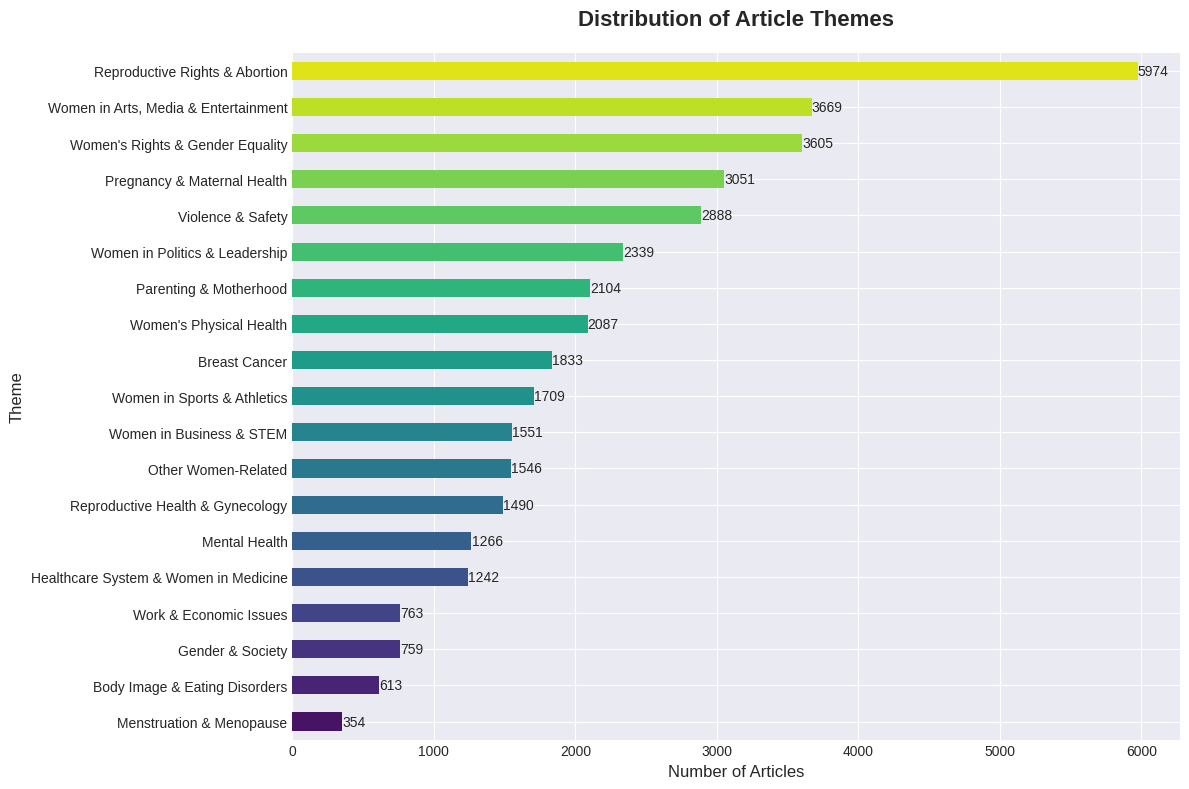


📈 Chart 2: Top Themes Over Time (Percentage)


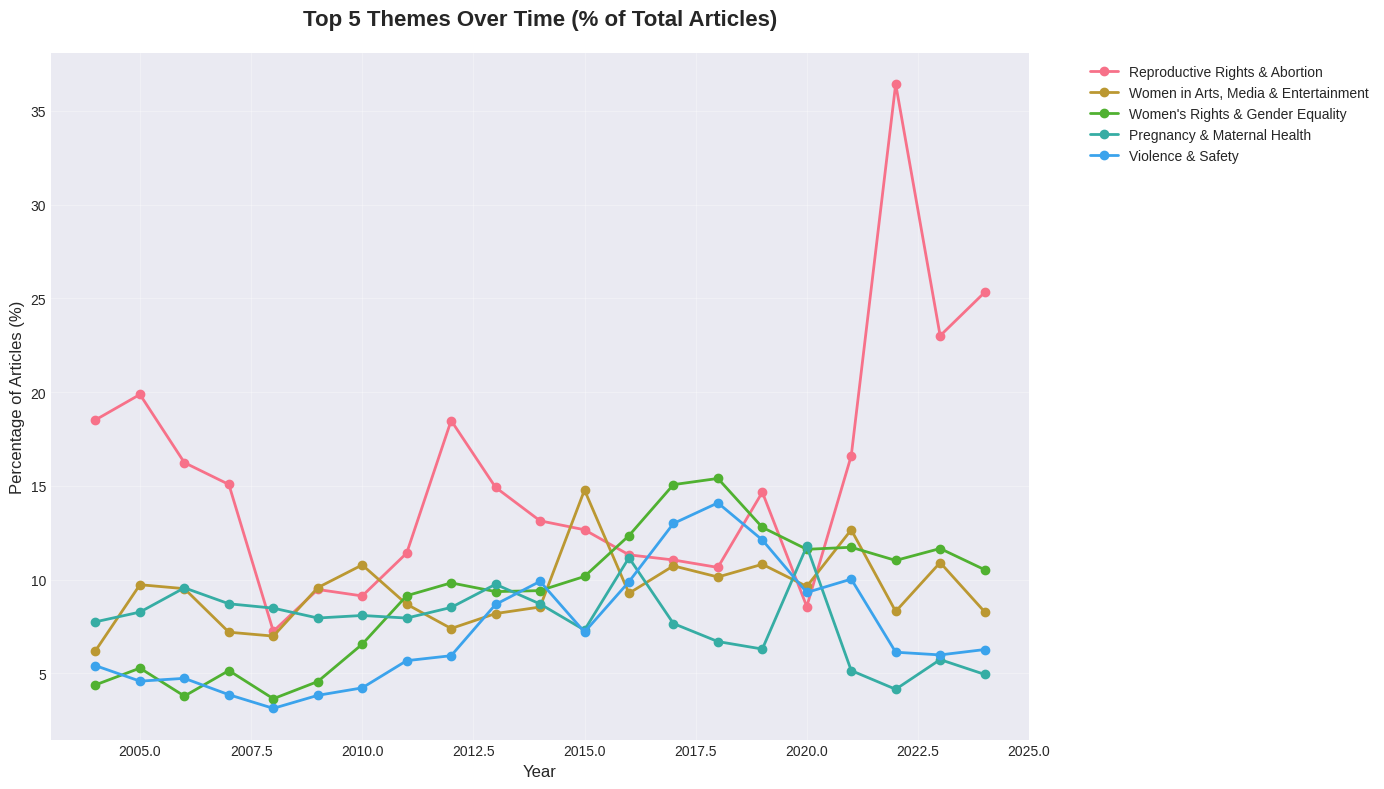


🔥 Chart 3: Theme Heatmap by Year (Percentage)


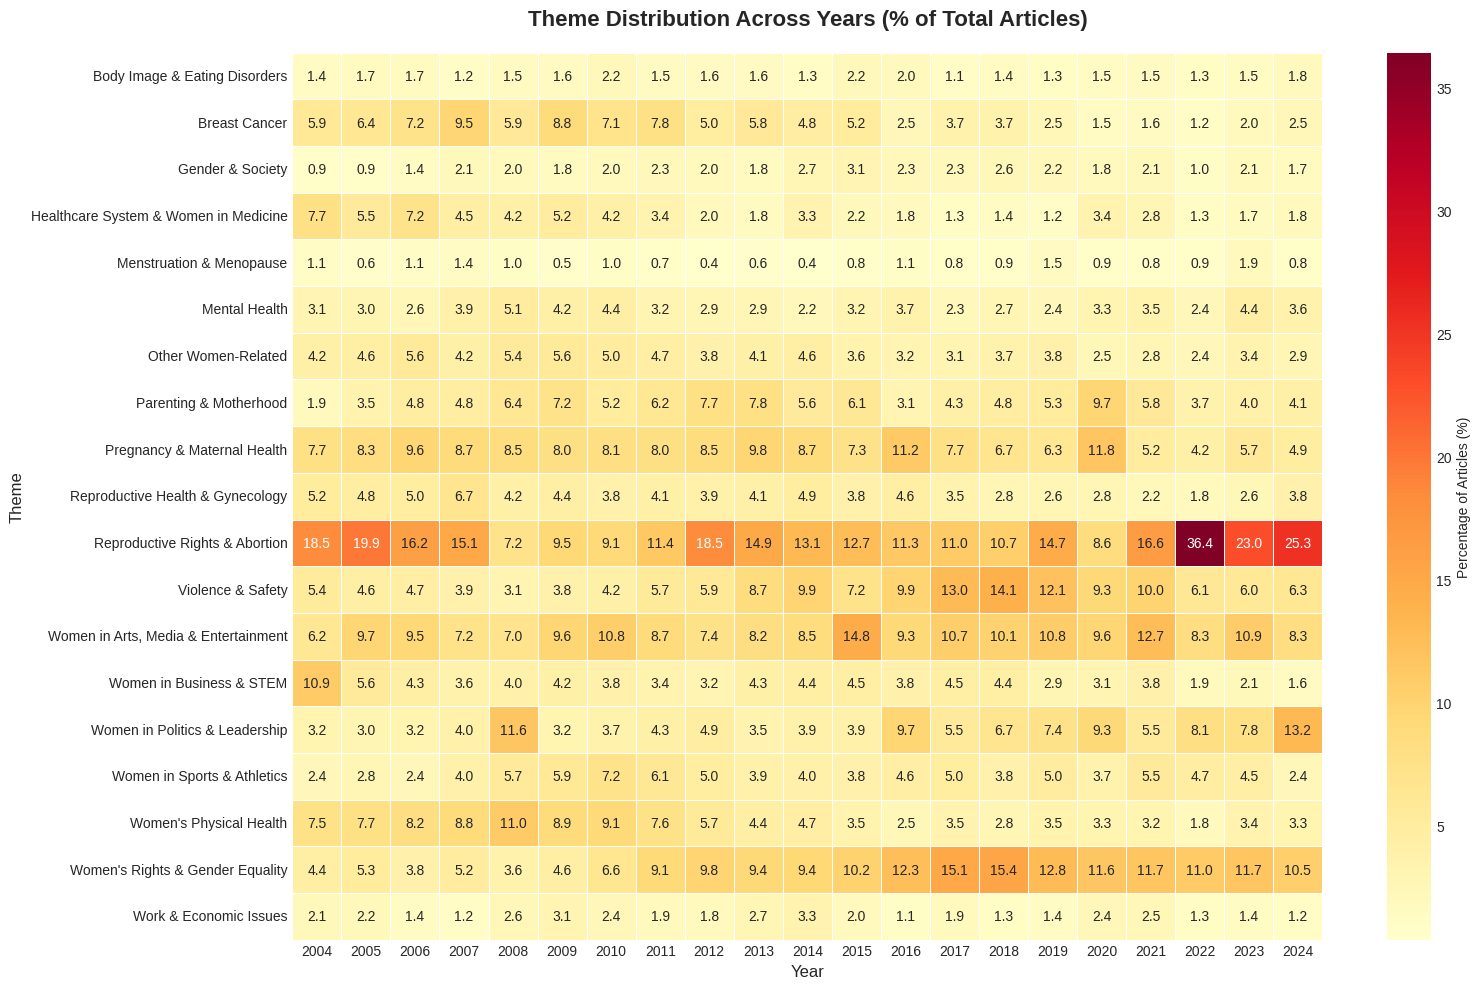


📊 Chart 4: 100% Stacked Bar Chart by Year


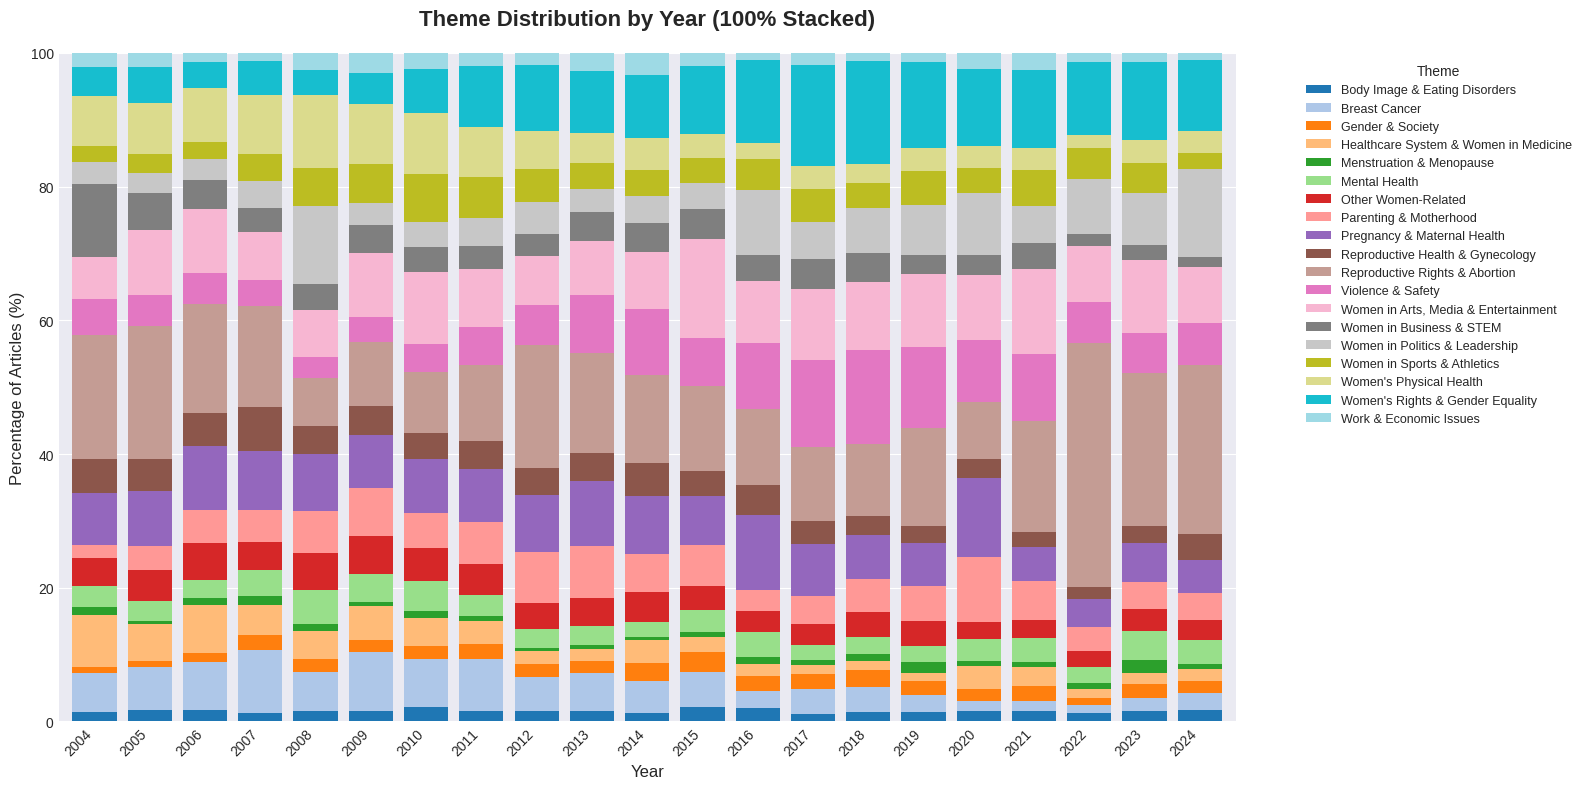


📊 Chart 5: 100% Stacked Bar Chart by Year-Month


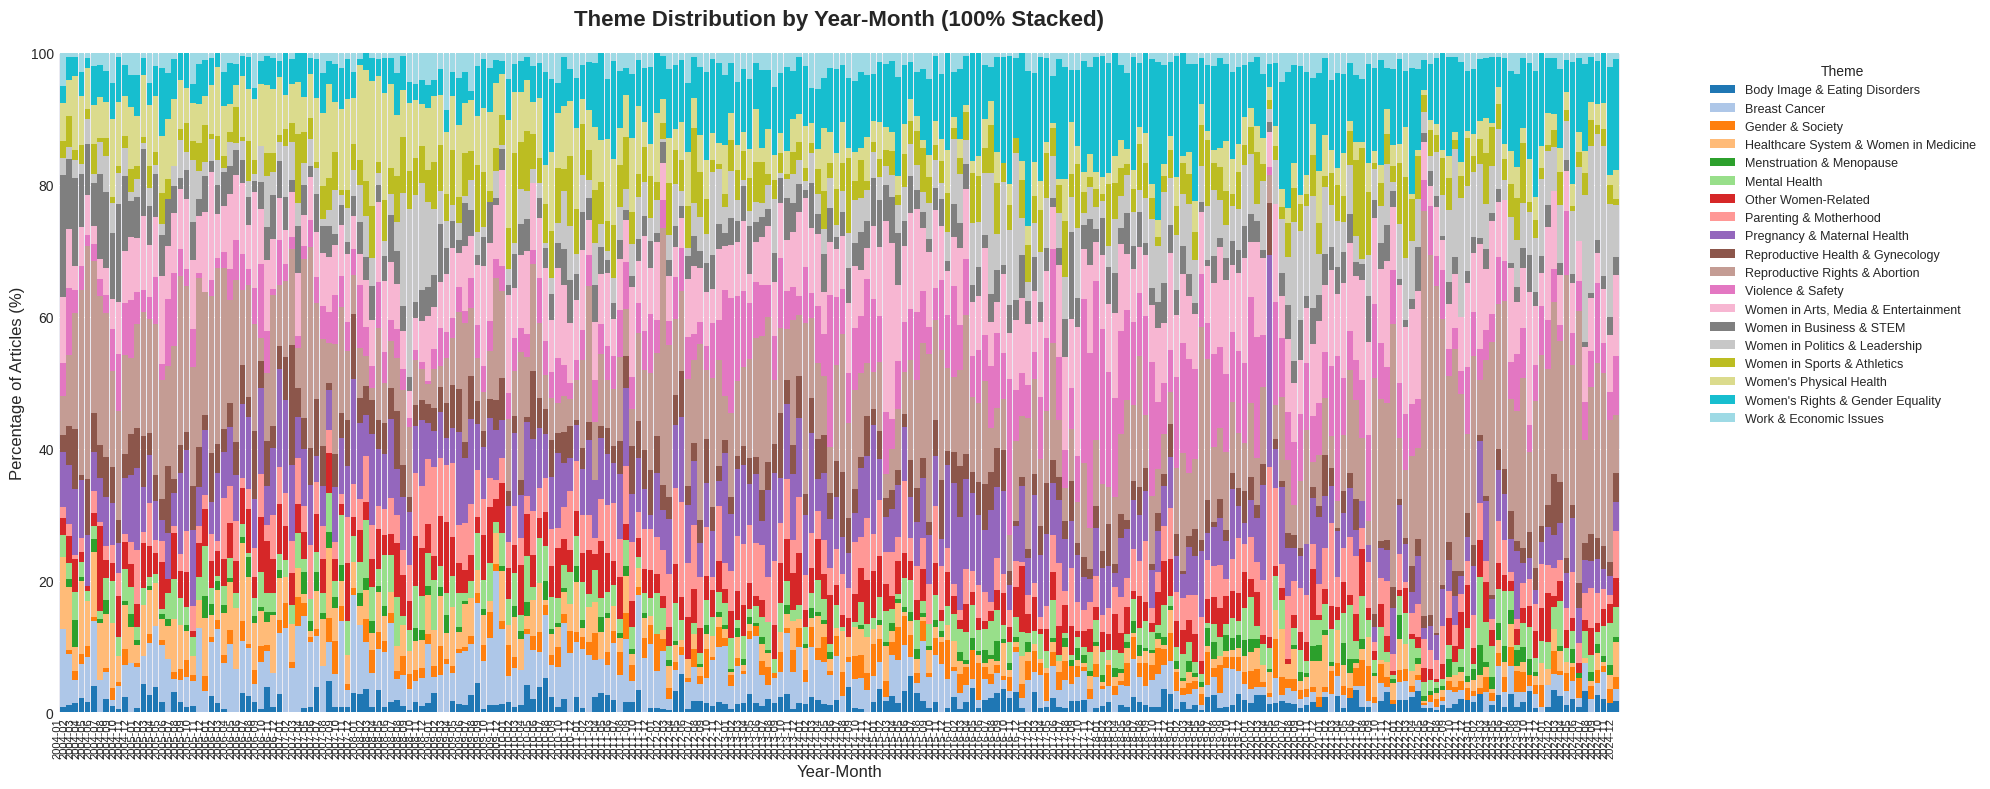


📈 Chart 6: Theme Growth/Decline Analysis
Comparing years 2015-2019 vs 2020-2024


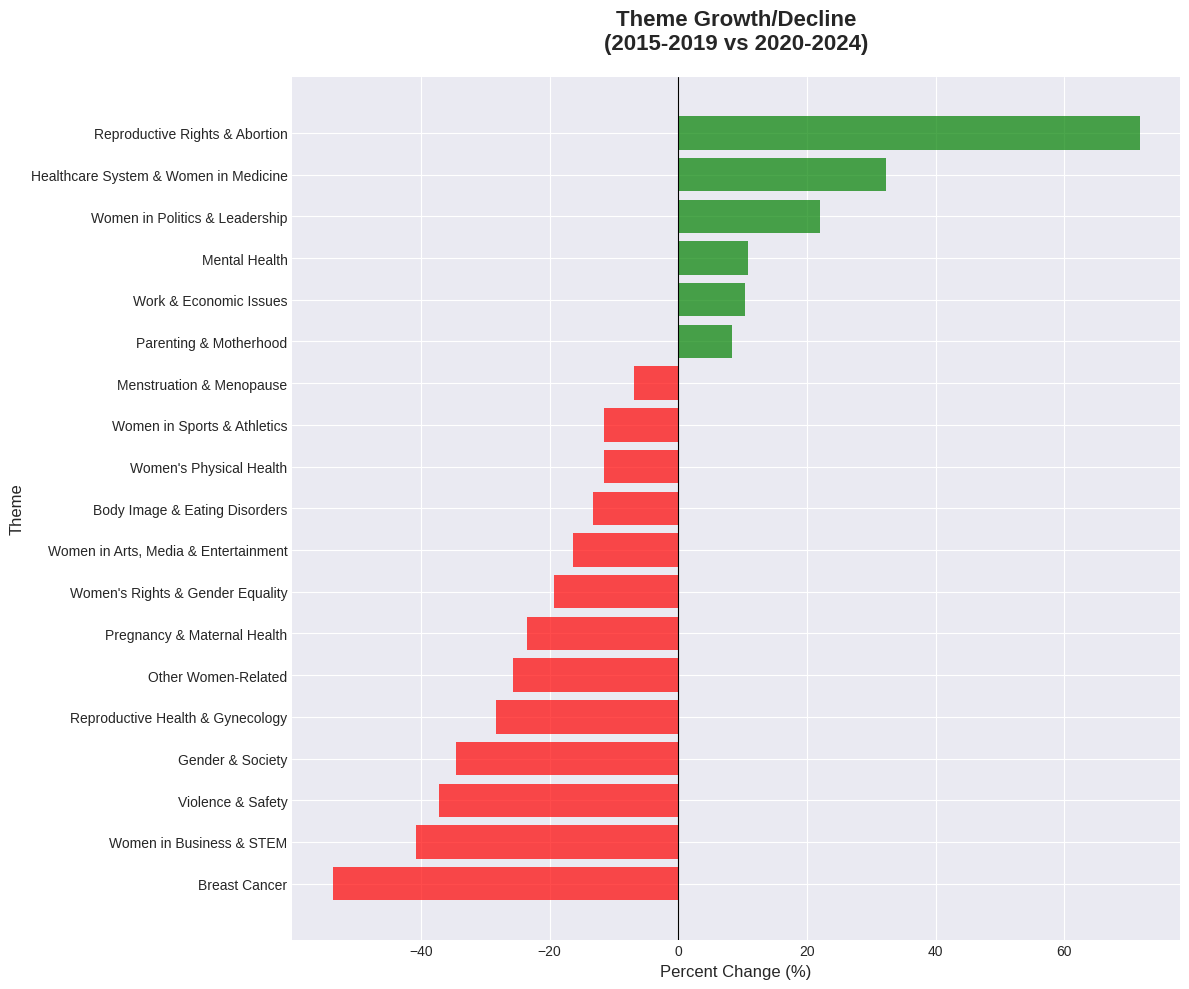


📋 Table 7D: Theme Percentages by News Desk

THEME DISTRIBUTION BY NEWS DESK (% of Desk Total)
news_desk                                 0    ALS   Arts  Arts & Ideas/Cultural Desk  Arts and Leisure Desk  Arts&Leisure  AtHome  Automobiles    BKS  Book Review Desk  BookReview  Books  Books / First Chapters  Books / Sunday Book Review  Business  Business / Media & Advertising  Business/Financial Desk   CUL   Cars  Circuits  CityWeekly  Climate  College  Connecticut Weekly Desk  ContinuousNews  Culture  Dealbook  Dining  Dining In, Dining Out/Style Desk  Dining, Dining Out/Cultural Desk  EdLife  Editorial  Editorial Desk  Education  Education Life Supplement  Election Analytics  Escapes  Express  Fashions of The Times Magazine  Foreign  Foreign Desk  Games  Gender  Giving  Graphics  Headway  Health  Health & Fitness  Health&Fitness  Home  House & Home/Style Desk  Insider  International  International / Americas  International / Asia Pacific  International / Europe  International / Middle 

In [103]:
run_all_analyses(claude_final)

# Summary and Recommendations

Women's health coverage in the NYT has significantly increased, rising from 1.7-2.4% in the mid-2000s to 4.2% recently, despite an overall decline in article volume, which highlights its elevated editorial priority.

Reproductive rights and abortion are the dominant themes, representing nearly 6,000 articles, with a 36% spike in 2022 likely due to the Dobbs decision. Other top themes include women in arts, media, and entertainment, women's rights and gender equality, and pregnancy and maternal health.

The 2020-2024 period saw a significant rise in reproductive rights (60%), healthcare system issues (39%), and women in politics (25%) coverage, reflecting heightened political discourse. Conversely, breast cancer coverage declined by 46%, and other traditional health topics also decreased, signaling a shift from a health-medical to a political-social framing of women's health.

As a news business, the rise of sociopolitical narratives, particularly the spike in reproductive rights coverage in 2022, including the sustained impact of post-Dobbs makes sense and it shows how the relevance of women’s health has increased. However, to maintain a comprehensive scope, it is also important to ensure space for crucial medical topics, such as breast cancer and reproductive health, as well as to highlight women in business and STEM, which are currently missed opportunities. While mental health coverage is consistent, expanding on this would also be beneficial for coverage.
